In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
# Load dataset
file_path = "borg_traces_data.csv"
df = pd.read_csv(file_path)

# Keep only the columns needed for simulation
columns_to_keep = [
    "start_time", "end_time", "collection_id",
    "scheduling_class", "priority", "collection_type",
    "resource_request", "average_usage", "assigned_memory"
]

# Trim the dataframe
df = df[columns_to_keep]


#### Filter out json column values and create new columns

In [10]:
import ast

# Ensure fields are parsed from string to dictionary
for col in ["resource_request", "average_usage"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else {})

# Extract CPU and memory from resource_request
df["requested_cpu"] = df["resource_request"].apply(lambda x: x.get("cpus", np.nan))
df["requested_memory"] = df["resource_request"].apply(lambda x: x.get("memory", np.nan))

# Extract CPU and memory from average_usage
df["used_cpu"] = df["average_usage"].apply(lambda x: x.get("cpus", np.nan))
df["used_memory"] = df["average_usage"].apply(lambda x: x.get("memory", np.nan))

df.drop(columns=["resource_request", "average_usage"], inplace=True)

Output Columns:
- requested_cpu and requested_memory: what the job asked for.
- used_cpu and used_memory: what it actually consumed on average.

#### Data Preparation

In [11]:
# 1. Basic sanity check: drop tasks with missing critical values
df.dropna(subset=[
    "start_time", "end_time", "used_cpu", "used_memory", 
    "requested_cpu", "requested_memory"
], inplace=True)

# 2. Compute task duration in minutes
df["duration_min"] = (df["end_time"] - df["start_time"]) / 60_000_000  # microseconds to minutes

# Drop tasks with negative or zero duration
df = df[df["duration_min"] > 0]

# 3. Outlier removal using IQR for CPU and memory usage
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, "used_cpu")
df = remove_outliers_iqr(df, "used_memory")

# 4. Optional: Drop zero-usage microtasks (very short and low-utilization)
df = df[~((df["used_cpu"] < 0.001) & (df["used_memory"] < 0.001))]

# 6. Convert microseconds to datetime (assuming Google’s offset: 1970-01-01 + 600s)
epoch_offset = pd.to_datetime("2019-05-01") + pd.to_timedelta(600, unit='s')
df["start_datetime"] = df["start_time"].apply(lambda x: epoch_offset + pd.to_timedelta(x, unit='us'))

# Extract date only
df["start_date"] = df["start_datetime"].dt.date

#### Task classification

In [12]:
def classify_flexibility(row):
    sc = row["scheduling_class"]
    priority = row["priority"]
    ctype = row["collection_type"]

    if sc == 3:
        return "Rigid"
    elif sc in [1, 2]:
        return "Flexible"
    elif sc == 0 or (priority <= 99 and ctype == 1):  # '1' => Batch
        return "Semi-Flexible"
    else:
        return "Unknown"

df["flexibility_class"] = df.apply(classify_flexibility, axis=1)

#### Compute GPU Usage and total utilization

In [13]:
ALPHA = 1.0
BETA = 7.0 
GAMMA = 0.5 

def estimate_gpu(row):
    # Basic linear combination of resource proxies
    base_gpu = 0.6 * row["used_cpu"] + 0.2 * row["used_memory"]
    
    # Scheduling Class as latency signal
    if row["scheduling_class"] == 3:         # latency-critical
        base_gpu *= 1.3
    elif row["scheduling_class"] in [1, 0]:  # batch-like
        base_gpu *= 0.8

    # Priority tiers (simplified)
    if row["priority"] >= 200:
        base_gpu *= 1.2
    elif row["priority"] <= 99:
        base_gpu *= 0.8

    # Optional: Cap extreme estimates
    return min(base_gpu, 1.0)

df["estimated_gpu"] = df.apply(estimate_gpu, axis=1)

# Compute total utilization
df["compute_utilization"] = (
    ALPHA * df["used_cpu"] +
    BETA * df["estimated_gpu"] +
    GAMMA * df["used_memory"]
)

In [14]:
# Save for further analysis
df.to_csv("final_traces.csv", index=False)

#### Renewable integretion

In [25]:
# Load the CSV file (adjust path as needed)
df_ren = pd.read_csv("summer_avg_per_minute.csv")

# Convert 'local_time' from string to datetime.time
df_ren['local_time'] = pd.to_datetime(df_ren['local_time'], format='%H:%M:%S').dt.time

# Convert the rest to float (if needed)
df_ren['wind_electricity'] = pd.to_numeric(df_ren['wind_electricity'], errors='coerce')
df_ren['pv_electricity'] = pd.to_numeric(df_ren['pv_electricity'], errors='coerce')
df_ren['total_renewable_energy'] = pd.to_numeric(df_ren['total_renewable_energy'], errors='coerce')

In [26]:
# Save for further analysis
df_ren.to_csv("Renewables_Summer.csv", index=False)

### Merge Traces with Renewables

#### Month May (Spring, Summer, Fall, Winter)

In [ ]:
# 1. Load traces and renewables
df_traces = pd.read_csv("final_traces.csv", parse_dates=["start_datetime"])
df_ren_spring = pd.read_csv("Renewables_Spring.csv")
df_ren_summer = pd.read_csv("Renewables_Summer.csv")
df_ren_fall = pd.read_csv("Renewables_Fall.csv")
df_ren_winter = pd.read_csv("Renewables_Winter.csv")

# 2. Round start_datetime to nearest minute (truncate seconds, microseconds)
df_traces["minute"] = df_traces["start_datetime"].dt.floor("min").dt.time

# 3. Extract date from start_datetime to filter
df_traces["start_date"] = df_traces["start_datetime"].dt.date

# 4. Prepare renewables: parse and extract time
# Spring
df_ren_spring["local_time"] = pd.to_datetime(df_ren_spring["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren_spring["minute"] = df_ren_spring["local_time"].dt.time  # Now extract just the time (HH:MM:SS)
# Summer
df_ren_summer["local_time"] = pd.to_datetime(df_ren_summer["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren_summer["minute"] = df_ren_summer["local_time"].dt.time  # Now extract just the time (HH:MM:SS)
# Fall
df_ren_fall["local_time"] = pd.to_datetime(df_ren_fall["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren_fall["minute"] = df_ren_fall["local_time"].dt.time  # Now extract just the time (HH:MM:SS)
# Witner
df_ren_winter["local_time"] = pd.to_datetime(df_ren_winter["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren_winter["minute"] = df_ren_winter["local_time"].dt.time  # Now extract just the time (HH:MM:SS)

# Merge with renewables data
df_merged_spring = pd.merge(df_traces, df_ren_spring, on="minute", how="left")
df_merged_summer = pd.merge(df_traces, df_ren_summer, on="minute", how="left")
df_merged_fall = pd.merge(df_traces, df_ren_fall, on="minute", how="left")
df_merged_winter = pd.merge(df_traces, df_ren_winter, on="minute", how="left")
    
# Save the result
output_filename_spring = "spring_traces_renewables_merged_v2.csv"
df_merged_spring.to_csv(output_filename_spring, index=False)

# Save the result
output_filename_summer = "summer_traces_renewables_merged_v2.csv"
df_merged_summer.to_csv(output_filename_summer, index=False)

# Save the result
output_filename_fall = "fall_traces_renewables_merged_v2.csv"
df_merged_fall.to_csv(output_filename_fall, index=False)

# Save the result
output_filename_winter = "winter_traces_renewables_merged_v2.csv"
df_merged_winter.to_csv(output_filename_winter, index=False)


#### Single days

#### Spring

In [7]:
# 1. Load traces and renewables
df_traces = pd.read_csv("final_traces.csv", parse_dates=["start_datetime"])
df_ren = pd.read_csv("Renewables_Spring.csv")

# 2. Round start_datetime to nearest minute (truncate seconds, microseconds)
df_traces["minute"] = df_traces["start_datetime"].dt.floor("min").dt.time

# 3. Extract date from start_datetime to filter
df_traces["start_date"] = df_traces["start_datetime"].dt.date

# 4. Prepare renewables: parse and extract time
df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren["minute"] = df_ren["local_time"].dt.time  # Now extract just the time (HH:MM:SS)


##### Use a specific day for the merge

In [8]:
import pandas as pd
from datetime import datetime, timedelta

# Loop through days in May 2019 (1 to 31)
for day in range(1, 32):
    # Format the day to two digits
    date_str = f"2019-05-{day:02d}"
    selected_day = pd.to_datetime(date_str).date()
    
    # Filter the data
    df_day = df_traces[df_traces["start_date"] == selected_day].copy()
    
    # Merge with renewables data
    df_merged = pd.merge(df_day, df_ren, on="minute", how="left")
    
    # Save the result
    output_filename = f"spring_{date_str}_merged.csv"
    df_merged.to_csv(output_filename, index=False)


#### Summer

In [9]:
# 1. Load traces and renewables
df_traces = pd.read_csv("final_traces.csv", parse_dates=["start_datetime"])
df_ren = pd.read_csv("Renewables_Summer.csv")

# 2. Round start_datetime to nearest minute (truncate seconds, microseconds)
df_traces["minute"] = df_traces["start_datetime"].dt.floor("min").dt.time

# 3. Extract date from start_datetime to filter
df_traces["start_date"] = df_traces["start_datetime"].dt.date

# 4. Prepare renewables: parse and extract time
df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren["minute"] = df_ren["local_time"].dt.time  # Now extract just the time (HH:MM:SS)


##### Use a specific day for the merge

In [10]:
import pandas as pd
from datetime import datetime, timedelta

# Loop through days in May 2019 (1 to 31)
for day in range(1, 32):
    # Format the day to two digits
    date_str = f"2019-05-{day:02d}"
    selected_day = pd.to_datetime(date_str).date()
    
    # Filter the data
    df_day = df_traces[df_traces["start_date"] == selected_day].copy()
    
    # Merge with renewables data
    df_merged = pd.merge(df_day, df_ren, on="minute", how="left")
    
    # Save the result
    output_filename = f"summer_{date_str}_merged.csv"
    df_merged.to_csv(output_filename, index=False)


#### Winter

In [32]:
# 1. Load traces and renewables
df_traces = pd.read_csv("final_traces_v2.csv", parse_dates=["start_datetime"])
df_ren = pd.read_csv("Renewables_Winter.csv")

# 2. Round start_datetime to nearest minute (truncate seconds, microseconds)
df_traces["minute"] = df_traces["start_datetime"].dt.floor("min").dt.time

# 3. Extract date from start_datetime to filter
df_traces["start_date"] = df_traces["start_datetime"].dt.date

# 4. Prepare renewables: parse and extract time
df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren["minute"] = df_ren["local_time"].dt.time  # Now extract just the time (HH:MM:SS)


##### Use a specific day for the merge

In [33]:
import pandas as pd
from datetime import datetime, timedelta

# Loop through days in May 2019 (1 to 31)
for day in range(1, 32):
    # Format the day to two digits
    date_str = f"2019-05-{day:02d}"
    selected_day = pd.to_datetime(date_str).date()
    
    # Filter the data
    df_day = df_traces[df_traces["start_date"] == selected_day].copy()
    
    # Merge with renewables data
    df_merged = pd.merge(df_day, df_ren, on="minute", how="left")
    
    # Save the result
    output_filename = f"winter_{date_str}_merged.csv"
    df_merged.to_csv(output_filename, index=False)


#### Fall

In [45]:
# 1. Load traces and renewables
df_traces = pd.read_csv("final_traces.csv", parse_dates=["start_datetime"])
df_ren = pd.read_csv("Renewables_Fall.csv")

# 2. Round start_datetime to nearest minute (truncate seconds, microseconds)
df_traces["minute"] = df_traces["start_datetime"].dt.floor("min").dt.time

# 3. Extract date from start_datetime to filter
df_traces["start_date"] = df_traces["start_datetime"].dt.date

# 4. Prepare renewables: parse and extract time
df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")  # Convert string to datetime
df_ren["minute"] = df_ren["local_time"].dt.time  # Now extract just the time (HH:MM:SS)


##### Use a specific day for the merge

In [46]:
import pandas as pd
from datetime import datetime, timedelta

# Loop through days in May 2019 (1 to 31)
for day in range(1, 32):
    # Format the day to two digits
    date_str = f"2019-05-{day:02d}"
    selected_day = pd.to_datetime(date_str).date()
    
    # Filter the data
    df_day = df_traces[df_traces["start_date"] == selected_day].copy()
    
    # Merge with renewables data
    df_merged = pd.merge(df_day, df_ren, on="minute", how="left")
    
    # Save the result
    output_filename = f"fall_{date_str}_merged.csv"
    df_merged.to_csv(output_filename, index=False)


#### Analysis

In [5]:
import pandas as pd

# === CSV laden ===
df = pd.read_csv("summer_traces_renewables_merged_v2.csv", parse_dates=["start_datetime"])


# === Datum extrahieren ===
df["date"] = df["start_datetime"].dt.date

# === Definierte Tage für Analyse ===
tage = ["2019-05-27", "2019-05-31", "2019-05-03"]
tage = [pd.to_datetime(t).date() for t in tage]

# === Filter auf relevante Tage ===
df_selected = df[df["date"].isin(tage)]

# === Berechne Kennzahlen pro Tag ===
summary = df_selected.groupby("date").agg(
    total_utilization=("compute_utilization", "sum"),
    task_count=("compute_utilization", "count")
).sort_values(by="total_utilization", ascending=False)

# === Ausgabe ===
print("📊 Auslastung & Task-Anzahl:")
print(summary)

# === Klassifizierung der Tage ===
print("\n🏷️ Klassifizierung nach Auslastung:")
print("🔺 Hohe Auslastung:", summary.index[0])
print("➖ Mittlere Auslastung:", summary.index[1])
print("🔻 Niedrige Auslastung:", summary.index[2])


📊 Auslastung & Task-Anzahl:
            total_utilization  task_count
date                                     
2019-05-03         101.737365        6397
2019-05-27          74.502097        3567
2019-05-31          69.363831        1927

🏷️ Klassifizierung nach Auslastung:
🔺 Hohe Auslastung: 2019-05-03
➖ Mittlere Auslastung: 2019-05-27
🔻 Niedrige Auslastung: 2019-05-31


In [24]:
import pandas as pd

# === CSV laden === #
df = pd.read_csv("summer_traces_renewables_merged_v2.csv")


# === local_time und compute_utilization vorbereiten === #
df["local_time"] = pd.to_datetime(df["local_time"])
df["time_bin"] = df["local_time"].dt.floor("30min")

# === Compute Utilization pro 30-Minuten-Intervall summieren === #
utilization_per_bin = df.groupby("time_bin")["compute_utilization"].sum()

# === Top 5 Intervalle mit höchster Last === #
top5_utilization = utilization_per_bin.sort_values(ascending=False).head(5)

# === Ausgabe === #
print("Top 5 halbstündige Intervalle mit höchster compute_utilization:")
for time, total_util in top5_utilization.items():
    print(f"{time.time()} – {total_util:.6f} total utilization")


Top 5 halbstündige Intervalle mit höchster compute_utilization:
06:00:00 – 236.806421 total utilization
07:00:00 – 186.694218 total utilization
03:00:00 – 180.618260 total utilization
12:00:00 – 127.287189 total utilization
10:00:00 – 125.343407 total utilization


In [25]:
df = pd.read_csv("summer_traces_renewables_merged_v2.csv")

import pandas as pd

# === local_time in datetime umwandeln === #
df["local_time"] = pd.to_datetime(df["local_time"])

# === Auf halbe Stunde runden === #
df["time_bin"] = df["local_time"].dt.floor("30min")

# === Anzahl Traces pro Zeitfenster === #
counts_per_bin = df["time_bin"].value_counts().sort_values(ascending=False)

# === Top 5 anzeigen === #
top5 = counts_per_bin.head(5)

# === Ausgabe === #
print("Top 5 halbstündige Intervalle mit den meisten Traces:")
for t, count in top5.items():
    print(f"{t.time()} – {count} Traces")



Top 5 halbstündige Intervalle mit den meisten Traces:
18:00:00 – 12228 Traces
04:30:00 – 12203 Traces
06:00:00 – 9421 Traces
08:00:00 – 9275 Traces
10:00:00 – 8997 Traces


In [27]:
# Mittelwertliche utilization pro trace (für 30-Minuten-Zeitslots)
avg_util_per_trace = df.groupby("time_bin")["compute_utilization"].mean()

# Top 5 Zeitpunkte nach durchschnittlicher utilization pro trace
top5_avg_util = avg_util_per_trace.sort_values(ascending=False).head(10)
print("Top Zeiten mit höchster durchschnittlicher compute_utilization pro Task:")
for t, v in top5_avg_util.items():
    print(f"{t.time()} – {v:.6f} avg utilization per task")


Top Zeiten mit höchster durchschnittlicher compute_utilization pro Task:
04:00:00 – 0.064029 avg utilization per task
00:00:00 – 0.059741 avg utilization per task
02:30:00 – 0.046166 avg utilization per task
06:00:00 – 0.045816 avg utilization per task
21:30:00 – 0.045362 avg utilization per task
12:30:00 – 0.039383 avg utilization per task
07:30:00 – 0.035430 avg utilization per task
08:30:00 – 0.034618 avg utilization per task
19:30:00 – 0.034106 avg utilization per task
01:00:00 – 0.034104 avg utilization per task


<Figure size 1600x600 with 0 Axes>

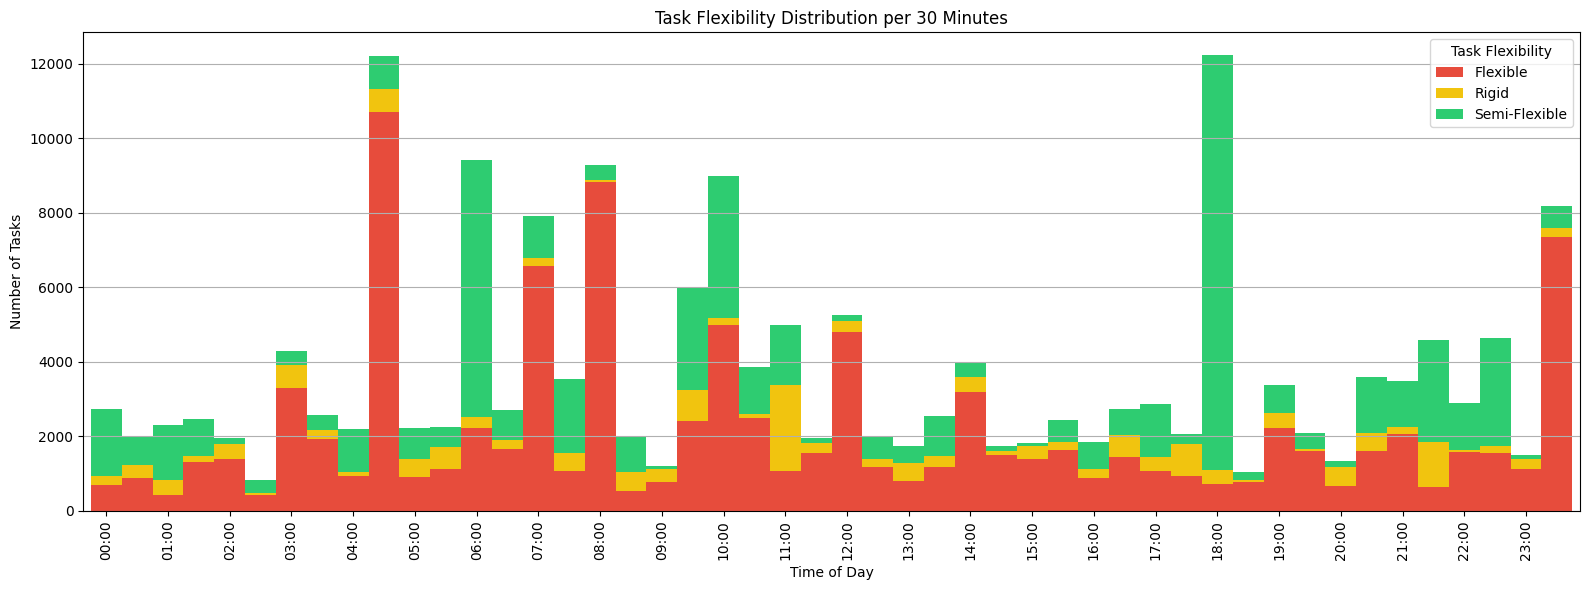

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# === CSV laden === #
df = pd.read_csv("summer_traces_renewables_merged_v2.csv")
df["local_time"] = pd.to_datetime(df["local_time"])

# Auf 30-Minuten-Intervalle runden
df["time_slot"] = df["local_time"].dt.floor("30min")

# Gruppieren nach Zeitfenster und Flexibility Class
half_hour_flex = df.groupby(["time_slot", "flexibility_class"]).size().unstack(fill_value=0)

# Zeitachse sortieren
half_hour_flex = half_hour_flex.sort_index()

# Plot: stacked bar chart
plt.figure(figsize=(16, 6))
half_hour_flex.plot(
    kind="bar",
    stacked=True,
    color=["#e74c3c", "#f1c40f", "#2ecc71"],  # Rigid, Semi-Flexible, Flexible
    figsize=(16, 6),
    width=1.0
)

plt.title("Task Flexibility Distribution per 30 Minutes")
plt.xlabel("Time of Day")
plt.ylabel("Number of Tasks")
plt.xticks(
    ticks=range(0, len(half_hour_flex.index), 2),
    labels=[t.strftime("%H:%M") for i, t in enumerate(half_hour_flex.index) if i % 2 == 0],
    rotation=90
)
plt.grid(axis="y")
plt.legend(title="Task Flexibility")
plt.tight_layout()
plt.show()


/tmp/ipykernel_81/158947323.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time_slot"] = df["start_datetime"].dt.floor("H")


<Figure size 1600x600 with 0 Axes>

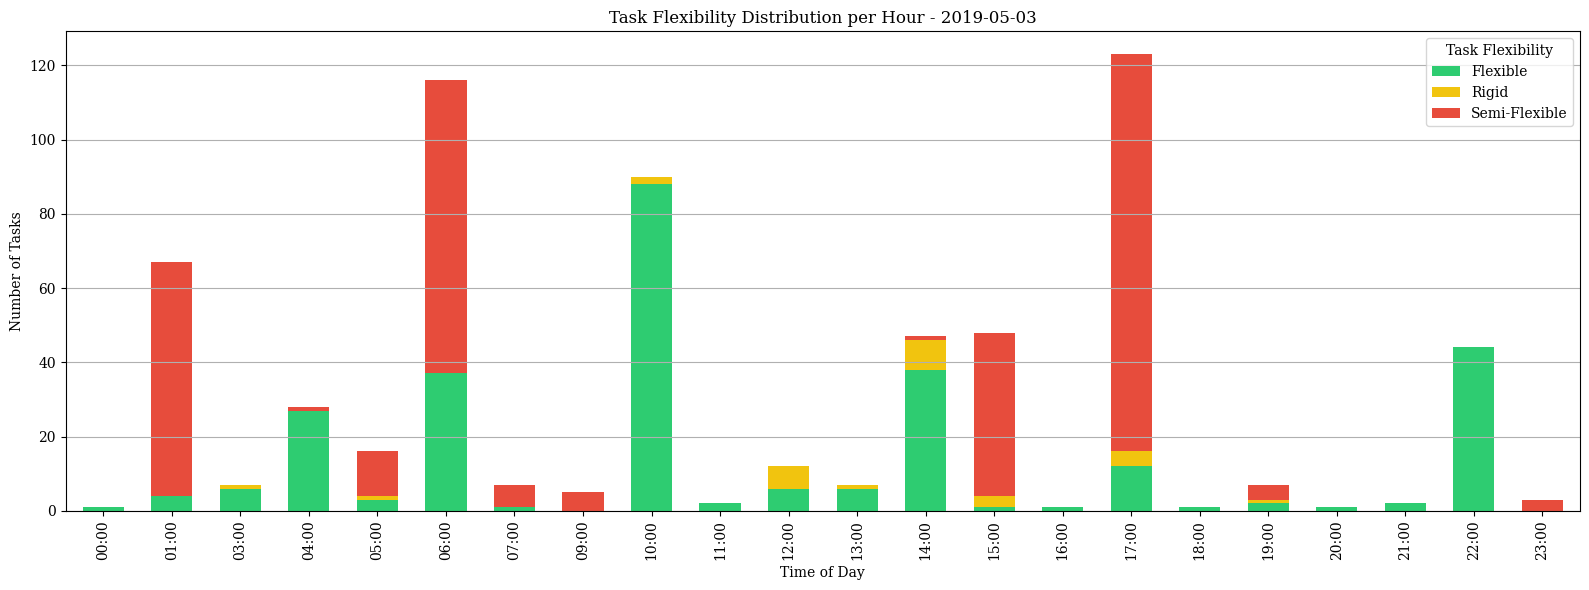

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# === Gesampelte Datei laden === #
df = pd.read_csv("sampled_2019-05-03.csv", parse_dates=["start_datetime"])

# Auf Stundenraster runden
df["time_slot"] = df["start_datetime"].dt.floor("H")

# Gruppieren nach Stunde und Flexibility Class
hourly_flex = df.groupby(["time_slot", "flexibility_class"]).size().unstack(fill_value=0)

# Zeitachse sortieren
hourly_flex = hourly_flex.sort_index()

# Plot: stacked bar chart
plt.figure(figsize=(16, 6))
hourly_flex.plot(
    kind="bar",
    stacked=True,
    color=["#2ecc71", "#f1c40f", "#e74c3c"],  # Flexible, Semi-Flexible, Rigid
    figsize=(16, 6),
    width=0.6

)

plt.title("Task Flexibility Distribution per Hour - 2019-05-03")
plt.xlabel("Time of Day")
plt.ylabel("Number of Tasks")
plt.xticks(
    ticks=range(0, len(hourly_flex.index), 1),
    labels=[t.strftime("%H:%M") for t in hourly_flex.index],
    rotation=90
)
plt.grid(axis="y")
plt.legend(title="Task Flexibility")
plt.tight_layout()
plt.show()


/tmp/ipykernel_81/199591784.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time_slot"] = df["start_datetime"].dt.floor("H")


<Figure size 1600x600 with 0 Axes>

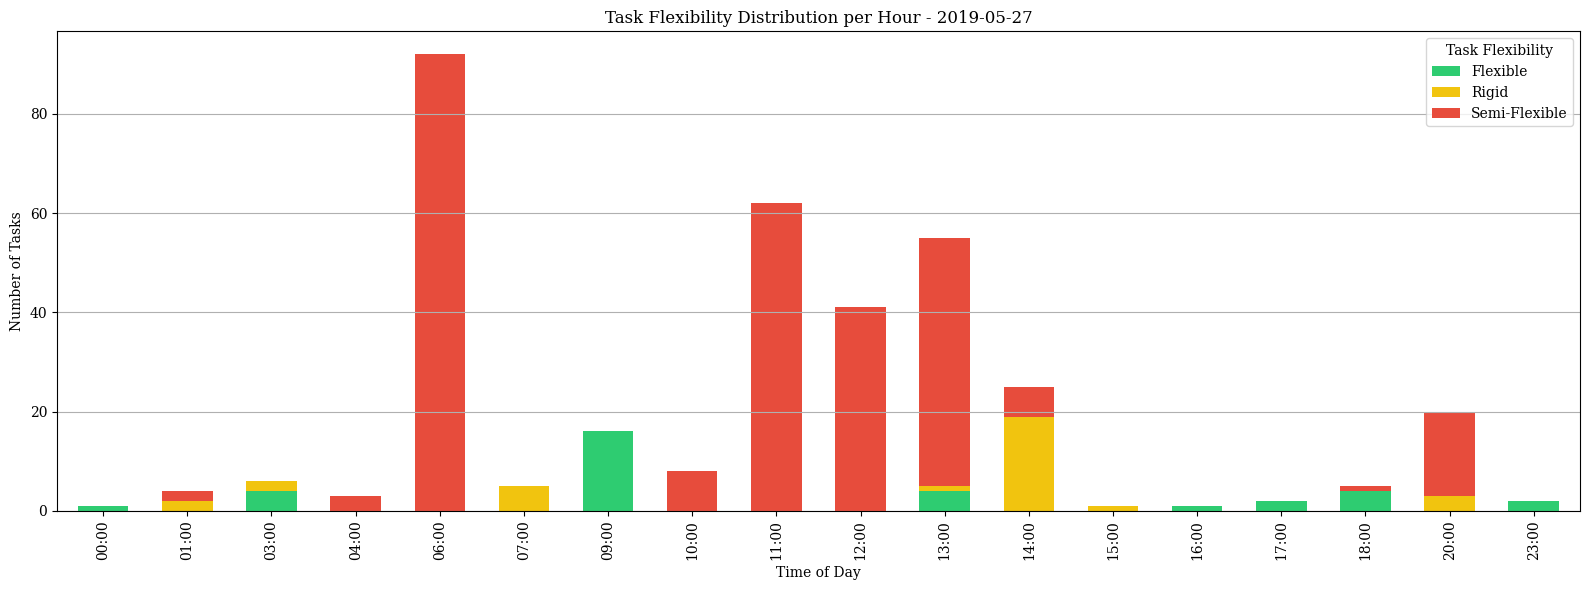

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# === Gesampelte Datei laden === #
df = pd.read_csv("sampled_2019-05-27.csv", parse_dates=["start_datetime"])

# Auf Stundenraster runden
df["time_slot"] = df["start_datetime"].dt.floor("H")

# Gruppieren nach Stunde und Flexibility Class
hourly_flex = df.groupby(["time_slot", "flexibility_class"]).size().unstack(fill_value=0)

# Zeitachse sortieren
hourly_flex = hourly_flex.sort_index()

# Plot: stacked bar chart
plt.figure(figsize=(16, 6))
hourly_flex.plot(
    kind="bar",
    stacked=True,
    color=["#2ecc71", "#f1c40f", "#e74c3c"],  # Flexible, Semi-Flexible, Rigid
    figsize=(16, 6),
    width=0.6

)

plt.title("Task Flexibility Distribution per Hour - 2019-05-27")
plt.xlabel("Time of Day")
plt.ylabel("Number of Tasks")
plt.xticks(
    ticks=range(0, len(hourly_flex.index), 1),
    labels=[t.strftime("%H:%M") for t in hourly_flex.index],
    rotation=90
)
plt.grid(axis="y")
plt.legend(title="Task Flexibility")
plt.tight_layout()
plt.show()


/tmp/ipykernel_81/3452424399.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time_slot"] = df["start_datetime"].dt.floor("H")


<Figure size 1600x600 with 0 Axes>

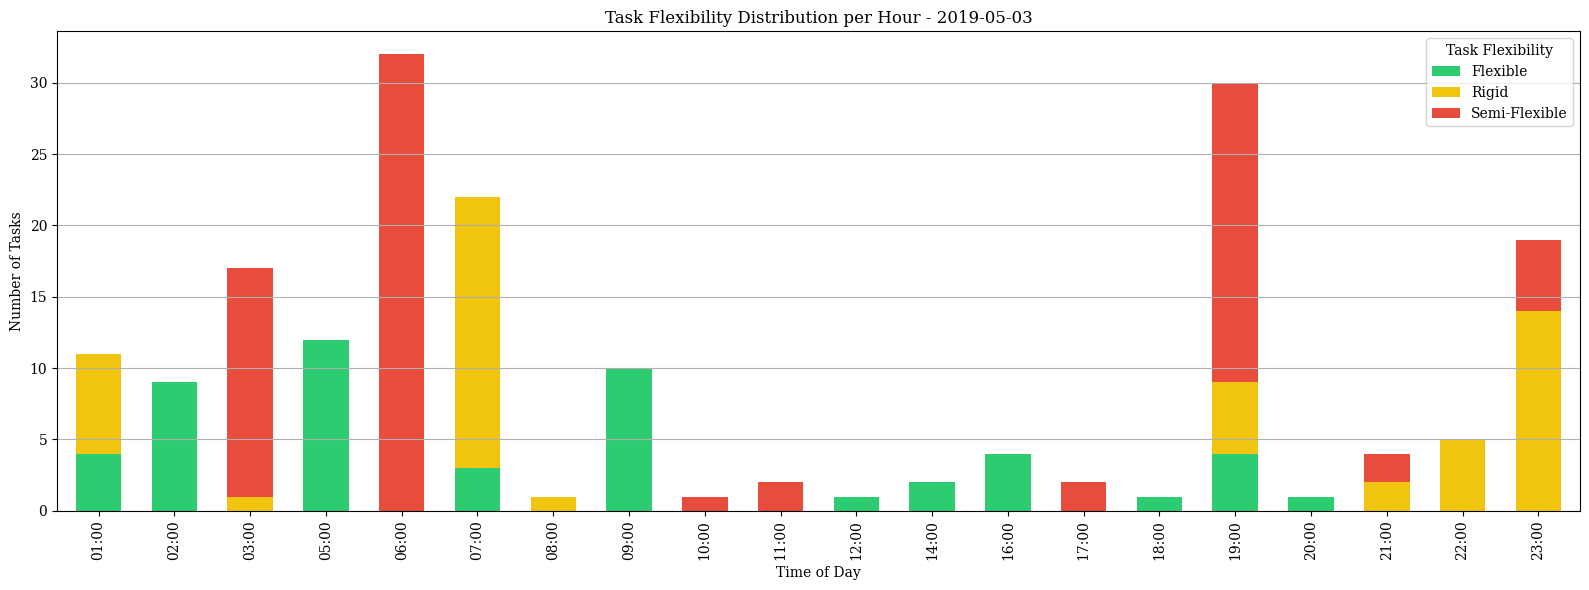

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# === Gesampelte Datei laden === #
df = pd.read_csv("sampled_2019-05-31.csv", parse_dates=["start_datetime"])

# Auf Stundenraster runden
df["time_slot"] = df["start_datetime"].dt.floor("H")

# Gruppieren nach Stunde und Flexibility Class
hourly_flex = df.groupby(["time_slot", "flexibility_class"]).size().unstack(fill_value=0)

# Zeitachse sortieren
hourly_flex = hourly_flex.sort_index()

# Plot: stacked bar chart
plt.figure(figsize=(16, 6))
hourly_flex.plot(
    kind="bar",
    stacked=True,
    color=["#2ecc71", "#f1c40f", "#e74c3c"],  # Flexible, Semi-Flexible, Rigid
    figsize=(16, 6),
    width=0.6

)

plt.title("Task Flexibility Distribution per Hour - 2019-05-03")
plt.xlabel("Time of Day")
plt.ylabel("Number of Tasks")
plt.xticks(
    ticks=range(0, len(hourly_flex.index), 1),
    labels=[t.strftime("%H:%M") for t in hourly_flex.index],
    rotation=90
)
plt.grid(axis="y")
plt.legend(title="Task Flexibility")
plt.tight_layout()
plt.show()


/tmp/ipykernel_81/1359501356.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["time_slot"] = df["start_datetime"].dt.floor("H")


<Figure size 1600x600 with 0 Axes>

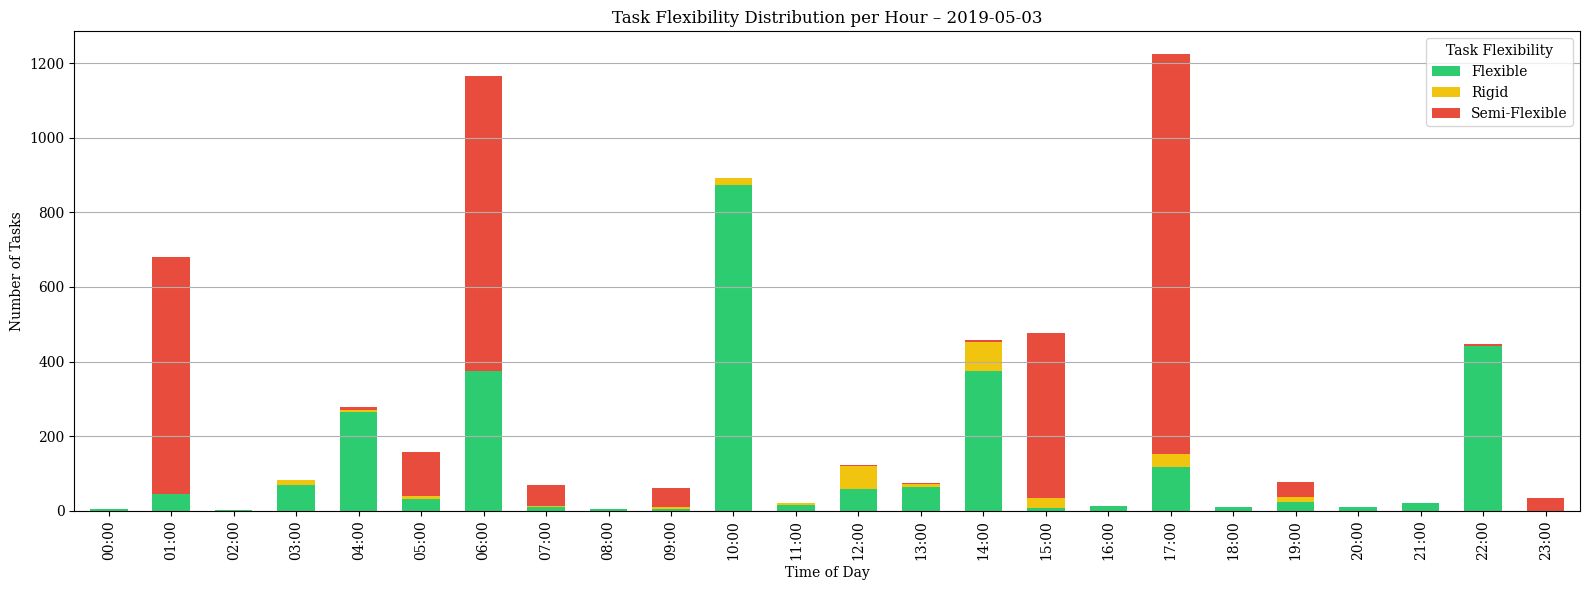

<Figure size 1600x600 with 0 Axes>

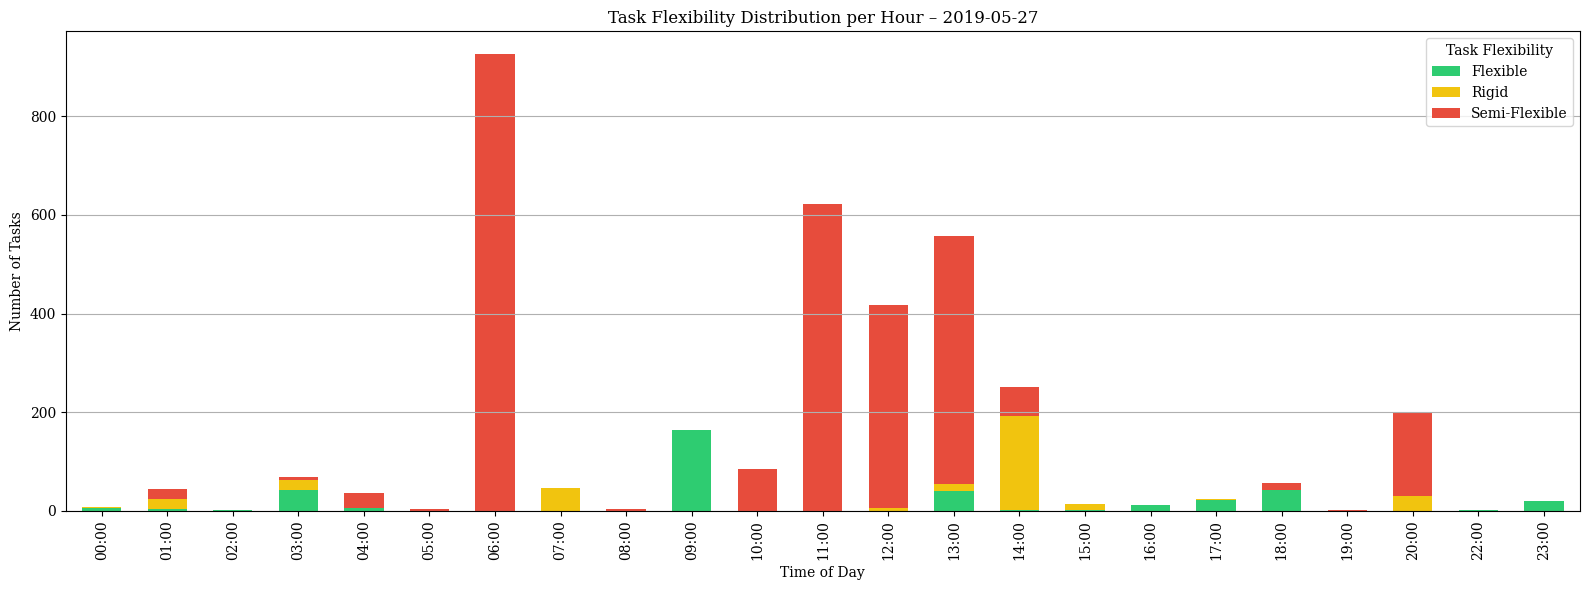

<Figure size 1600x600 with 0 Axes>

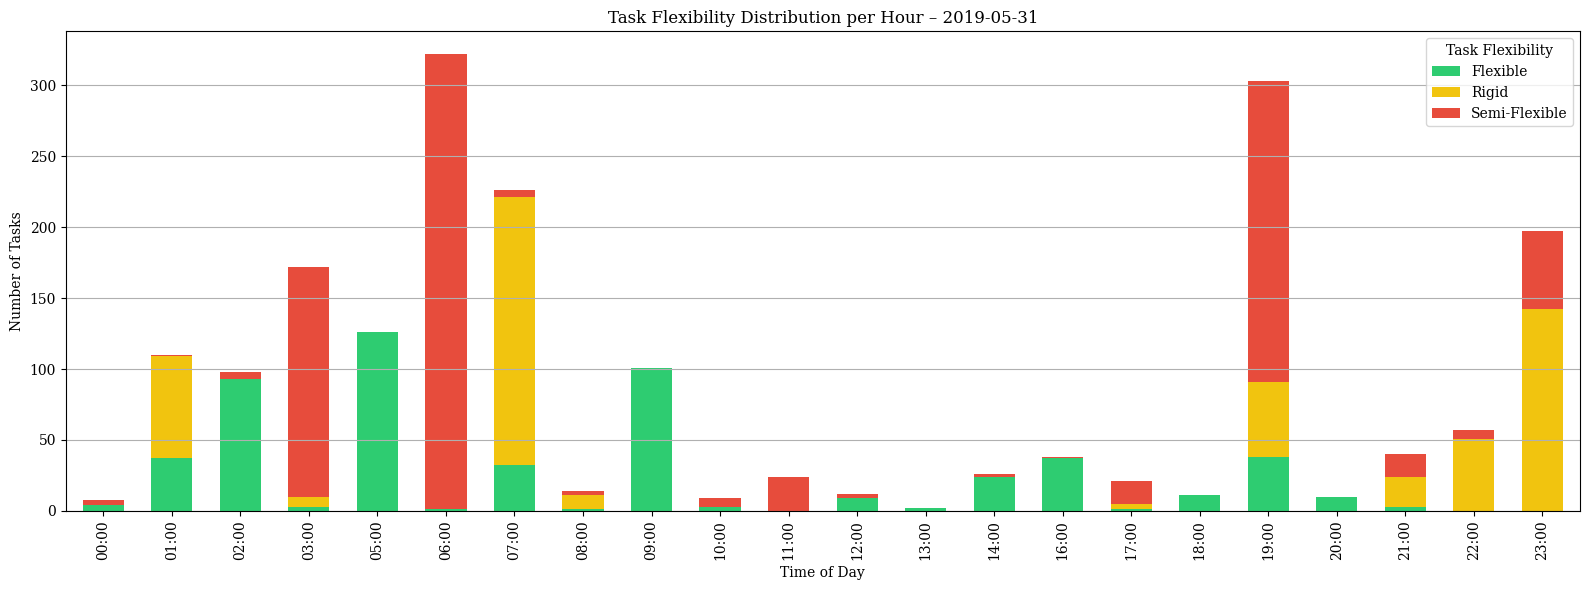

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# === Komplette Datei laden === #
df = pd.read_csv("final_traces.csv", parse_dates=["start_datetime"])

# === Ziel-Tage === #
days = ["2019-05-03", "2019-05-27", "2019-05-31"]

# === Vorbereitung === #
df["start_date"] = df["start_datetime"].dt.date
df["time_slot"] = df["start_datetime"].dt.floor("H")

# === Farbzuordnung (fix, wie gehabt) === #
color_map = {
    "Flexible": "#2ecc71",
    "Semi-Flexible": "#e74c3c",
    "Rigid": "#f1c40f"
}

# === Plot für jeden Tag separat === #
for day in days:
    day_data = df[df["start_date"] == pd.to_datetime(day).date()].copy()
    hourly_flex = day_data.groupby(["time_slot", "flexibility_class"]).size().unstack(fill_value=0)
    hourly_flex = hourly_flex.sort_index()

    plt.figure(figsize=(16, 6))
    hourly_flex.plot(
        kind="bar",
        stacked=True,
        color=[color_map.get(col, "#999999") for col in hourly_flex.columns],
        figsize=(16, 6),
        width=0.6
    )

    plt.title(f"Task Flexibility Distribution per Hour – {day}")
    plt.xlabel("Time of Day")
    plt.ylabel("Number of Tasks")
    plt.xticks(
        ticks=range(0, len(hourly_flex.index), 1),
        labels=[t.strftime("%H:%M") for t in hourly_flex.index],
        rotation=90
    )
    plt.grid(axis="y")
    plt.legend(title="Task Flexibility")
    plt.tight_layout()
    plt.show()


In [4]:
def structured_task_sample(df_full, sample_size=300, random_state=42, utilization_bins=3):
    """
    Stratified sampling over flexibility_class, start_hour, and compute_utilization levels.
    Ensures structural representativeness of workload characteristics.
    """
    # Check required columns
    assert "flexibility_class" in df_full.columns
    assert "start_hour" in df_full.columns
    assert "compute_utilization" in df_full.columns

    # Step 1: Bucket utilization into quantile bins (e.g., low / medium / high)
    df_full["util_bin"] = pd.qcut(df_full["compute_utilization"], q=utilization_bins, labels=[f"U{i}" for i in range(utilization_bins)])

    # Step 2: Create full group key (flex class × hour × util level)
    df_full["group_key"] = (
        df_full["flexibility_class"].astype(str) + "_" +
        df_full["start_hour"].astype(str) + "_" +
        df_full["util_bin"].astype(str)
    )

    # Step 3: Proportional allocation
    group_sizes = df_full["group_key"].value_counts(normalize=True)
    group_sample_sizes = (group_sizes * sample_size).round().astype(int)

    # Step 4: Sampling
    sampled = []
    for group, n in group_sample_sizes.items():
        group_df = df_full[df_full["group_key"] == group]
        if len(group_df) >= n:
            sampled_group = group_df.sample(n=n, random_state=random_state)
        else:
            sampled_group = group_df  # fallback: n > verfügbar → alles nehmen
        sampled.append(sampled_group)

    df_sampled = pd.concat(sampled).drop(columns=["group_key", "util_bin"]).reset_index(drop=True)
    return df_sampled


#### Set scaling of utilization and renewables

In [5]:
import pandas as pd

# === Parameter === #
trace_file = "final_traces.csv"
days = ["2019-05-03", "2019-05-27", "2019-05-31"]
sampling_fraction = 0.1  # z. B. 10% der Tasks pro Tag behalten

# === Load full dataset === #
df_all = pd.read_csv(trace_file, parse_dates=["start_datetime"])
df_all["start_date"] = df_all["start_datetime"].dt.date
df_all["start_hour"] = df_all["start_datetime"].dt.hour

# === Prepare structure-sampled subsets === #
sampled_dfs = []
for day in days:
    df_day = df_all[df_all["start_date"] == pd.to_datetime(day).date()].copy()
    sample_size = int(len(df_day) * sampling_fraction)
    df_sampled = structured_task_sample(df_day, sample_size=sample_size)
    sampled_dfs.append(df_sampled)
    
    # === Speichern als CSV === #
    output_filename = f"sampled_{day}.csv".replace(":", "-")  # falls ":" im Datum wäre
    df_sampled.to_csv(output_filename, index=False)


In [6]:
# === Parameter === #
days = ["2019-05-03", "2019-05-27", "2019-05-31"]

# === Load sampled CSVs === #
sampled_all = []
for day in days:
    filename = f"sampled_{day}.csv".replace(":", "-")
    df_day = pd.read_csv(filename, parse_dates=["start_datetime"])
    df_day["start_date"] = df_day["start_datetime"].dt.date
    df_day["absolute_hour"] = df_day["start_datetime"].dt.hour
    sampled_all.append(df_day)

# === Combine into one DataFrame === #
df_sampled_all = pd.concat(sampled_all).reset_index(drop=True)

# === Compute global max of hourly utilization across all sampled days === #
global_max = 0
for day in days:
    day_data = df_sampled_all[df_sampled_all["start_date"] == pd.to_datetime(day).date()]
    hourly_util = day_data.groupby("absolute_hour")["compute_utilization"].sum()
    day_max = hourly_util.max()
    global_max = max(global_max, day_max)

In [7]:
global_max

1.7909170837402337

## Scenario 1

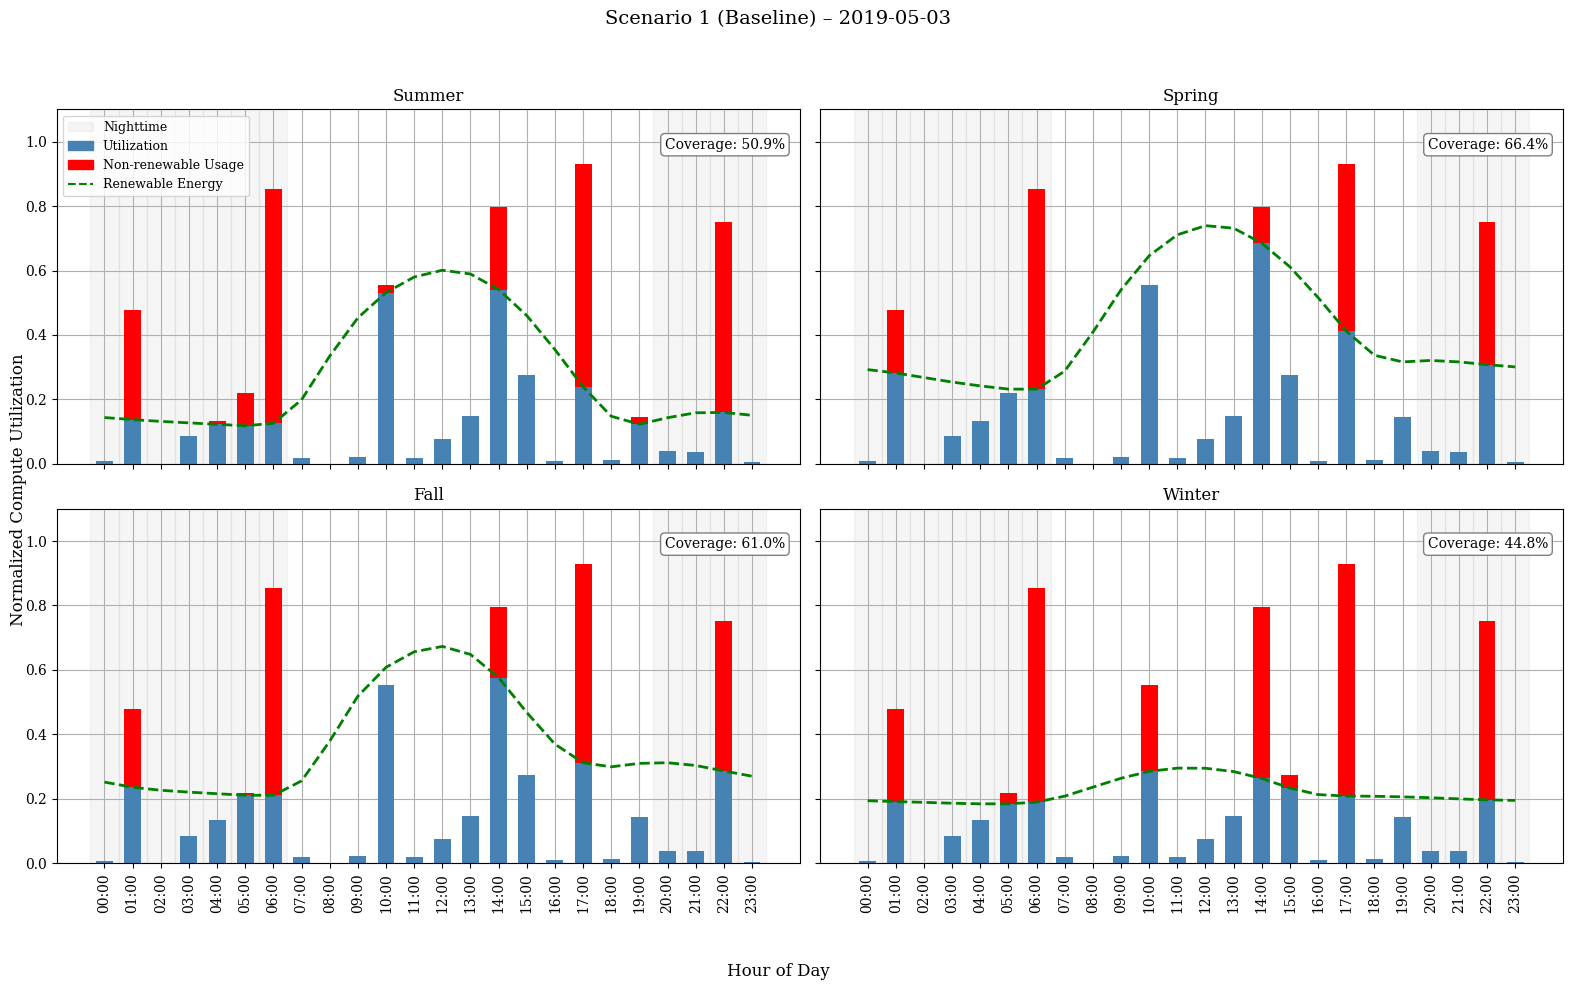

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Style === #
mpl.rcParams['font.family'] = 'serif'

# === Parameter === #
target_date = "2019-05-03"
traces_file = "sampled_2019-05-03.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5

# === Load traces once === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df["absolute_hour"] = df["start_datetime"].dt.hour
compute_per_hour = df.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)

# Normalisierung
normalized_util = compute_per_hour / global_max
x = np.arange(24)

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()

# === Farben und Legenden === #
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
]

# === Loop über Renewables-Files === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    normalized_renewable = renewable_scaled / global_max

    # Bars: blau (innerhalb), rot (überschuss)
    for hour in x:
        util_val = normalized_util[hour]
        renew_val = normalized_renewable[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.6, color="steelblue", zorder=2)
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.6, color="red", zorder=2)
        else:
            ax.bar(hour, util_val, width=0.6, color="steelblue", zorder=2)

    # Nachtstunden
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x, normalized_renewable, color='green', linestyle='--', linewidth=2, label='Renewable Energy', zorder=3)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{h:02d}:00" for h in x], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)
    

    # Coverage anzeigen
    coverage = np.minimum(normalized_util, normalized_renewable).sum() / normalized_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Achsenbeschriftungen
fig.suptitle(f"Scenario 1 (Baseline) – {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")

# Legende nur einmal
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_626/686315247.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/686315247.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_dateti

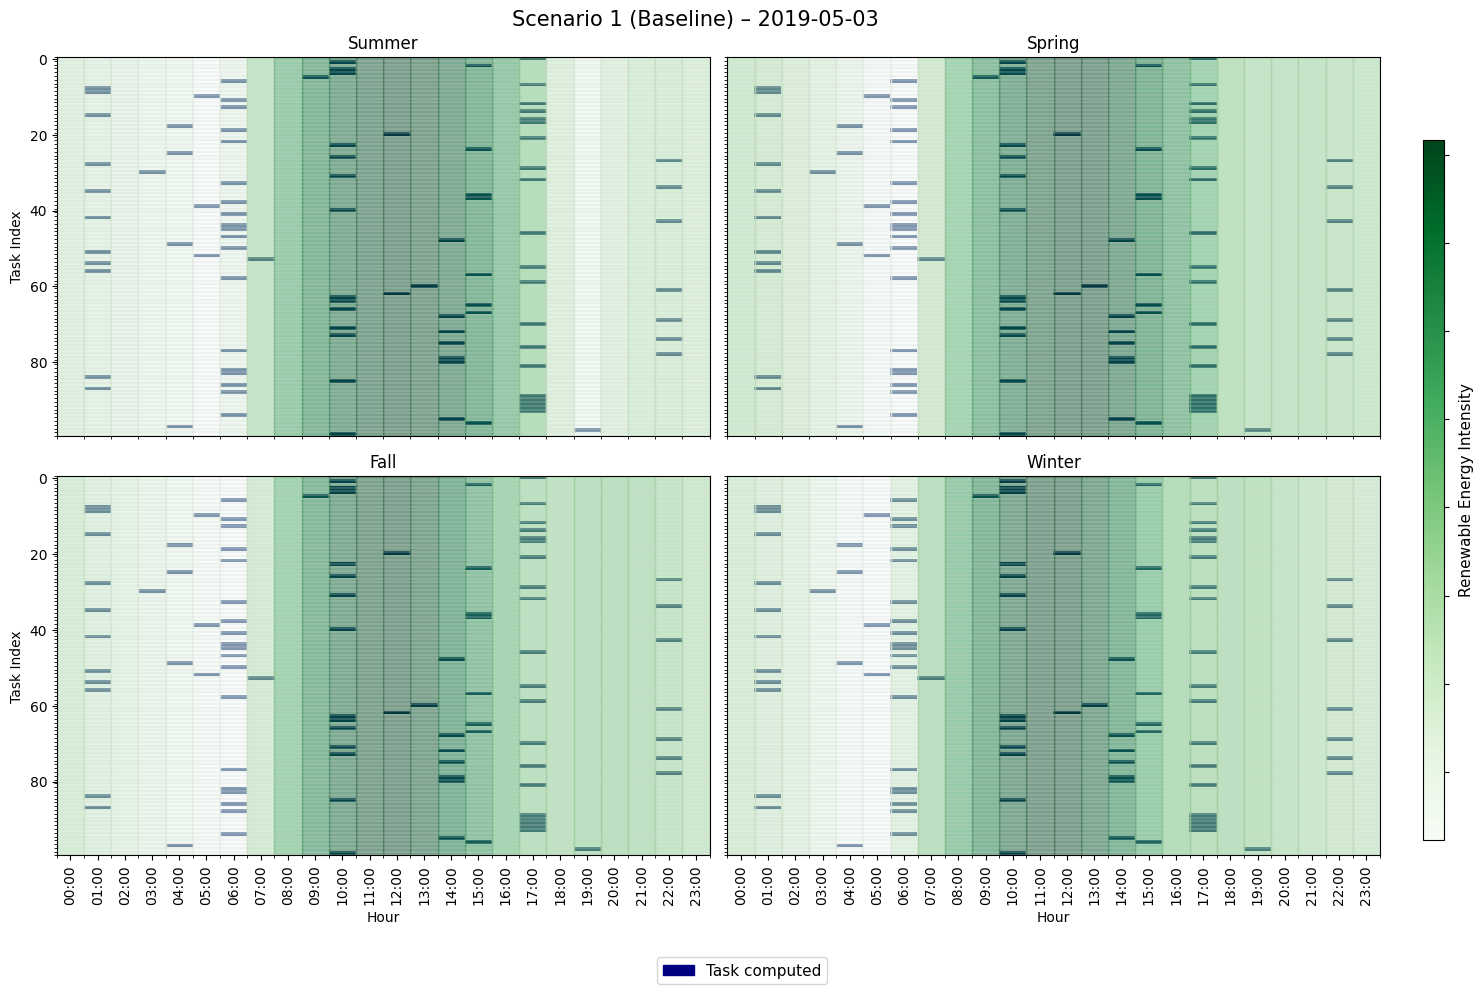

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# === Parameter === #
target_date = "2019-05-203"
trace_file = "sampled_2019-05-03.csv"
renewable_files = [
    ("Summer", "Renewables_Summer.csv"),
    ("Spring", "Renewables_Spring.csv"),
    ("Fall", "Renewables_Fall.csv"),
    ("Winter", "Renewables_Winter.csv")
]
scaling_factor = 1.5
gamma = 0.5  # for contrast

# === Load trace data === #
df = pd.read_csv(trace_file)
df["absolute_hour"] = df["start_datetime"].astype('datetime64[ns]').dt.hour

# === Sampling 100 tasks === #
counts = df["absolute_hour"].value_counts().sort_index()
proportions = counts / counts.sum()
task_counts = (proportions * 100).round().astype(int)

# Korrektur auf exakt 100 Tasks
delta = 100 - task_counts.sum()
adjustment_indices = task_counts.sort_values(ascending=(delta < 0)).index
for idx in adjustment_indices:
    task_counts[idx] += np.sign(delta)
    delta -= np.sign(delta)
    if delta == 0:
        break

# Sampling pro Stunde
df_sampled = pd.DataFrame()
for hour, n in task_counts.items():
    sampled = df[df["absolute_hour"] == hour].head(n)
    df_sampled = pd.concat([df_sampled, sampled])

df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# === Heatmap-Matrix vorbereiten === #
tasks = df_sampled.index.tolist()
time_slots = list(range(24))
heatmap_matrix = np.zeros((len(tasks), len(time_slots)))
for i, row in df_sampled.iterrows():
    hour = row["absolute_hour"]
    heatmap_matrix[i, hour] = 1

# === Plot (2x2 Grid) === #
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, (season, ren_file) in enumerate(renewable_files):
    ax = axs[idx]

    df_ren = pd.read_csv(ren_file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_hourly = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_hourly * scaling_factor
    renewable_norm = ((renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())) ** gamma
    renewable_colors = plt.cm.Greens(renewable_norm)

    # Hintergrundfärbung je Stunde
    for h in time_slots:
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # Binär-Matrix
    cax = ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenbeschriftung
    if idx in [2, 3]:
        ax.set_xlabel("Hour", fontsize=10)
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)], rotation=90)
    else:
        ax.set_xticks([])

    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])
        ax.set_ylabel("")
        
    # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)


    # Gitter
    ax.set_xticks(np.arange(-0.5, 24, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(tasks), 1), minor=True)
    ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.3)

# Legende und Colorbar
task_patch = mpatches.Patch(color='navy', label='Task computed')
fig.legend(handles=[task_patch], loc='lower center', ncol=4, fontsize=11)

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Platz für Colorbar außerhalb des gesamten Figure-Rahmens
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])  # [left, bottom, width, height]

norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=11)
cbar.ax.set_yticklabels([])  # Skalen entfernen



plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 1 (Baseline) – 2019-05-03", fontsize=15)
plt.show()


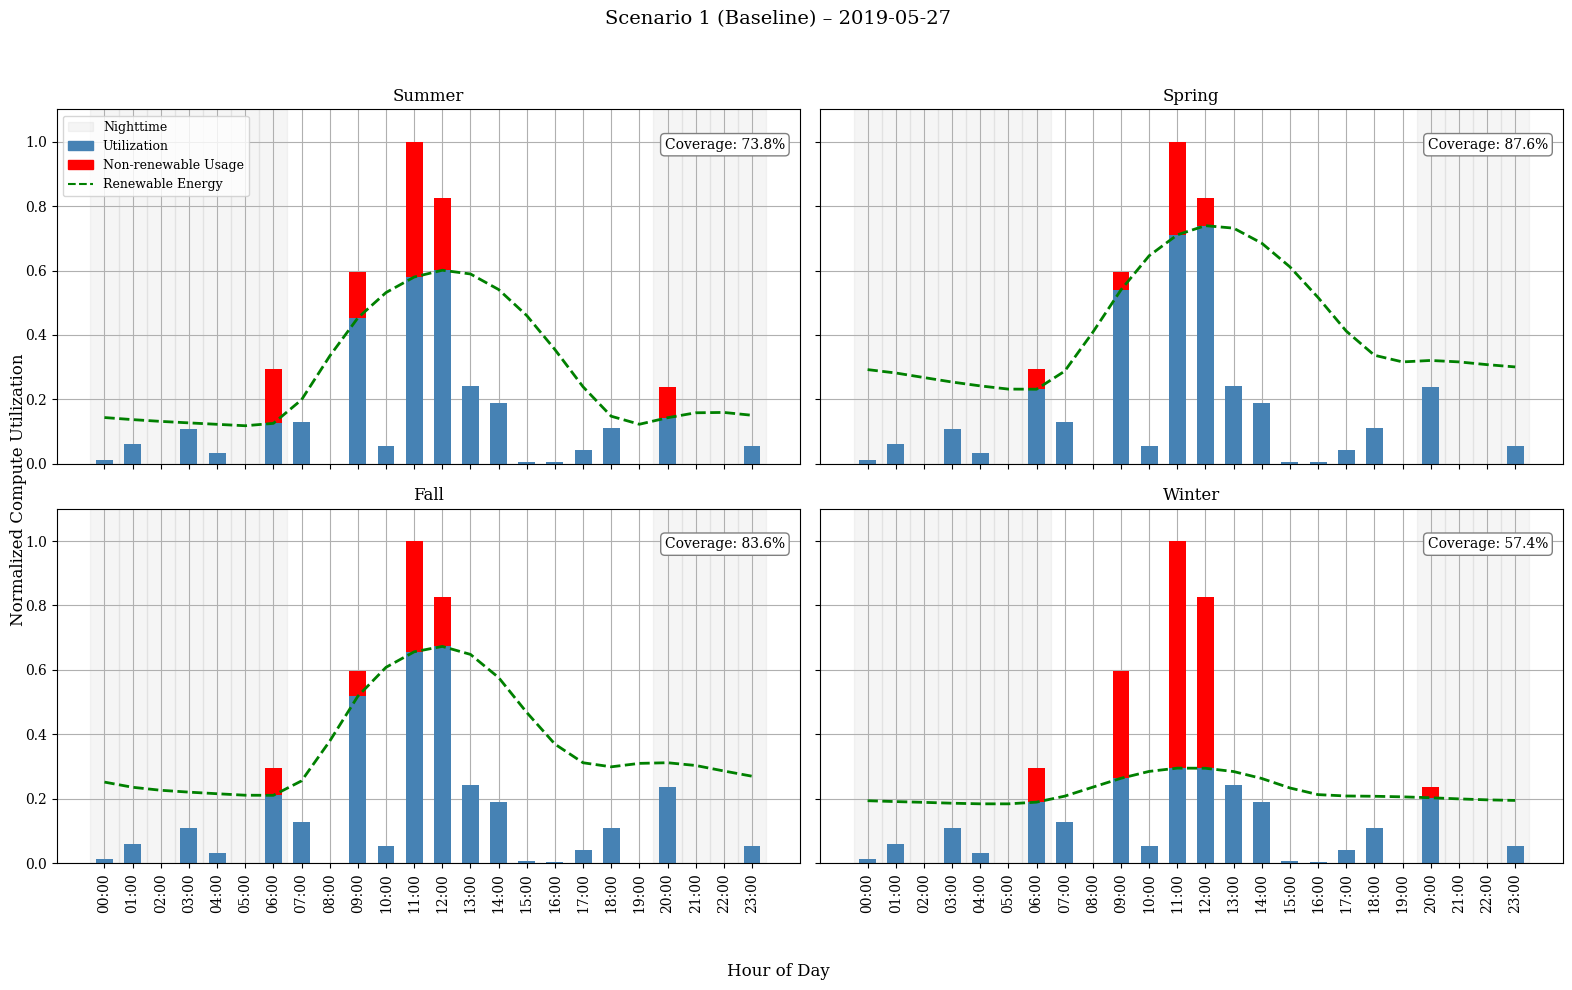

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Style === #
mpl.rcParams['font.family'] = 'serif'

# === Parameter === #
target_date = "2019-05-27"
traces_file = "sampled_2019-05-27.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5

# === Load traces once === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df["absolute_hour"] = df["start_datetime"].dt.hour
compute_per_hour = df.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)

# Normalisierung
normalized_util = compute_per_hour / global_max
x = np.arange(24)

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()

# === Farben und Legenden === #
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
]

# === Loop über Renewables-Files === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    normalized_renewable = renewable_scaled / global_max

    # Bars: blau (innerhalb), rot (überschuss)
    for hour in x:
        util_val = normalized_util[hour]
        renew_val = normalized_renewable[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.6, color="steelblue", zorder=2)
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.6, color="red", zorder=2)
        else:
            ax.bar(hour, util_val, width=0.6, color="steelblue", zorder=2)

    # Nachtstunden
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x, normalized_renewable, color='green', linestyle='--', linewidth=2, label='Renewable Energy', zorder=3)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{h:02d}:00" for h in x], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)

    # Coverage anzeigen
    coverage = np.minimum(normalized_util, normalized_renewable).sum() / normalized_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Achsenbeschriftungen
fig.suptitle(f"Scenario 1 (Baseline) – {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")

# Legende nur einmal
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_626/1279475222.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/1279475222.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/1279475222.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/1279475222.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To e

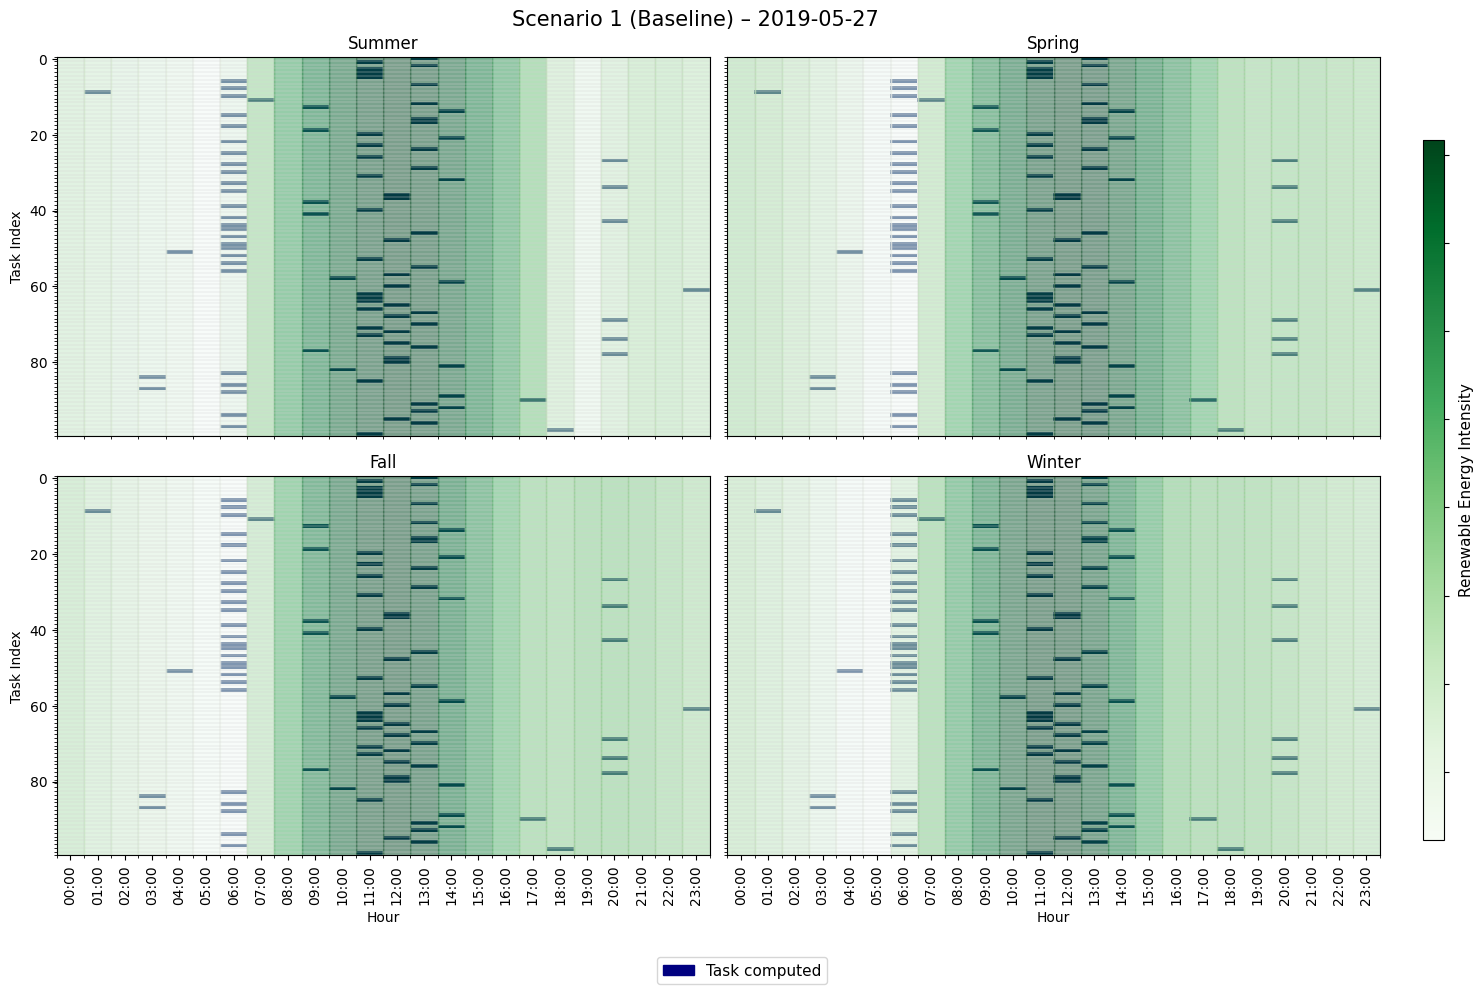

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# === Parameter === #
target_date = "2019-05-27"
trace_file = "sampled_2019-05-27.csv"
renewable_files = [
    ("Summer", "Renewables_Summer.csv"),
    ("Spring", "Renewables_Spring.csv"),
    ("Fall", "Renewables_Fall.csv"),
    ("Winter", "Renewables_Winter.csv")
]
scaling_factor = 1.5
gamma = 0.5  # for contrast

# === Load trace data === #
df = pd.read_csv(trace_file)
df["absolute_hour"] = df["start_datetime"].astype('datetime64[ns]').dt.hour

# === Sampling 100 tasks === #
counts = df["absolute_hour"].value_counts().sort_index()
proportions = counts / counts.sum()
task_counts = (proportions * 100).round().astype(int)

# Korrektur auf exakt 100 Tasks
delta = 100 - task_counts.sum()
adjustment_indices = task_counts.sort_values(ascending=(delta < 0)).index
for idx in adjustment_indices:
    task_counts[idx] += np.sign(delta)
    delta -= np.sign(delta)
    if delta == 0:
        break

# Sampling pro Stunde
df_sampled = pd.DataFrame()
for hour, n in task_counts.items():
    sampled = df[df["absolute_hour"] == hour].head(n)
    df_sampled = pd.concat([df_sampled, sampled])

df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# === Heatmap-Matrix vorbereiten === #
tasks = df_sampled.index.tolist()
time_slots = list(range(24))
heatmap_matrix = np.zeros((len(tasks), len(time_slots)))
for i, row in df_sampled.iterrows():
    hour = row["absolute_hour"]
    heatmap_matrix[i, hour] = 1

# === Plot (2x2 Grid) === #
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, (season, ren_file) in enumerate(renewable_files):
    ax = axs[idx]

    df_ren = pd.read_csv(ren_file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_hourly = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_hourly * scaling_factor
    renewable_norm = ((renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())) ** gamma
    renewable_colors = plt.cm.Greens(renewable_norm)

    # Hintergrundfärbung je Stunde
    for h in time_slots:
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # Binär-Matrix
    cax = ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenbeschriftung
    if idx in [2, 3]:
        ax.set_xlabel("Hour", fontsize=10)
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)], rotation=90)
    else:
        ax.set_xticks([])

    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])
        ax.set_ylabel("")
        
      # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)


    # Gitter
    ax.set_xticks(np.arange(-0.5, 24, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(tasks), 1), minor=True)
    ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.3)

# Legende und Colorbar
task_patch = mpatches.Patch(color='navy', label='Task computed')
fig.legend(handles=[task_patch], loc='lower center', ncol=4, fontsize=11)

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Platz für Colorbar außerhalb des gesamten Figure-Rahmens
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])  # [left, bottom, width, height]

norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=11)
cbar.ax.set_yticklabels([])  # Skalen entfernen



plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 1 (Baseline) – {target_date}", fontsize=15)
plt.show()


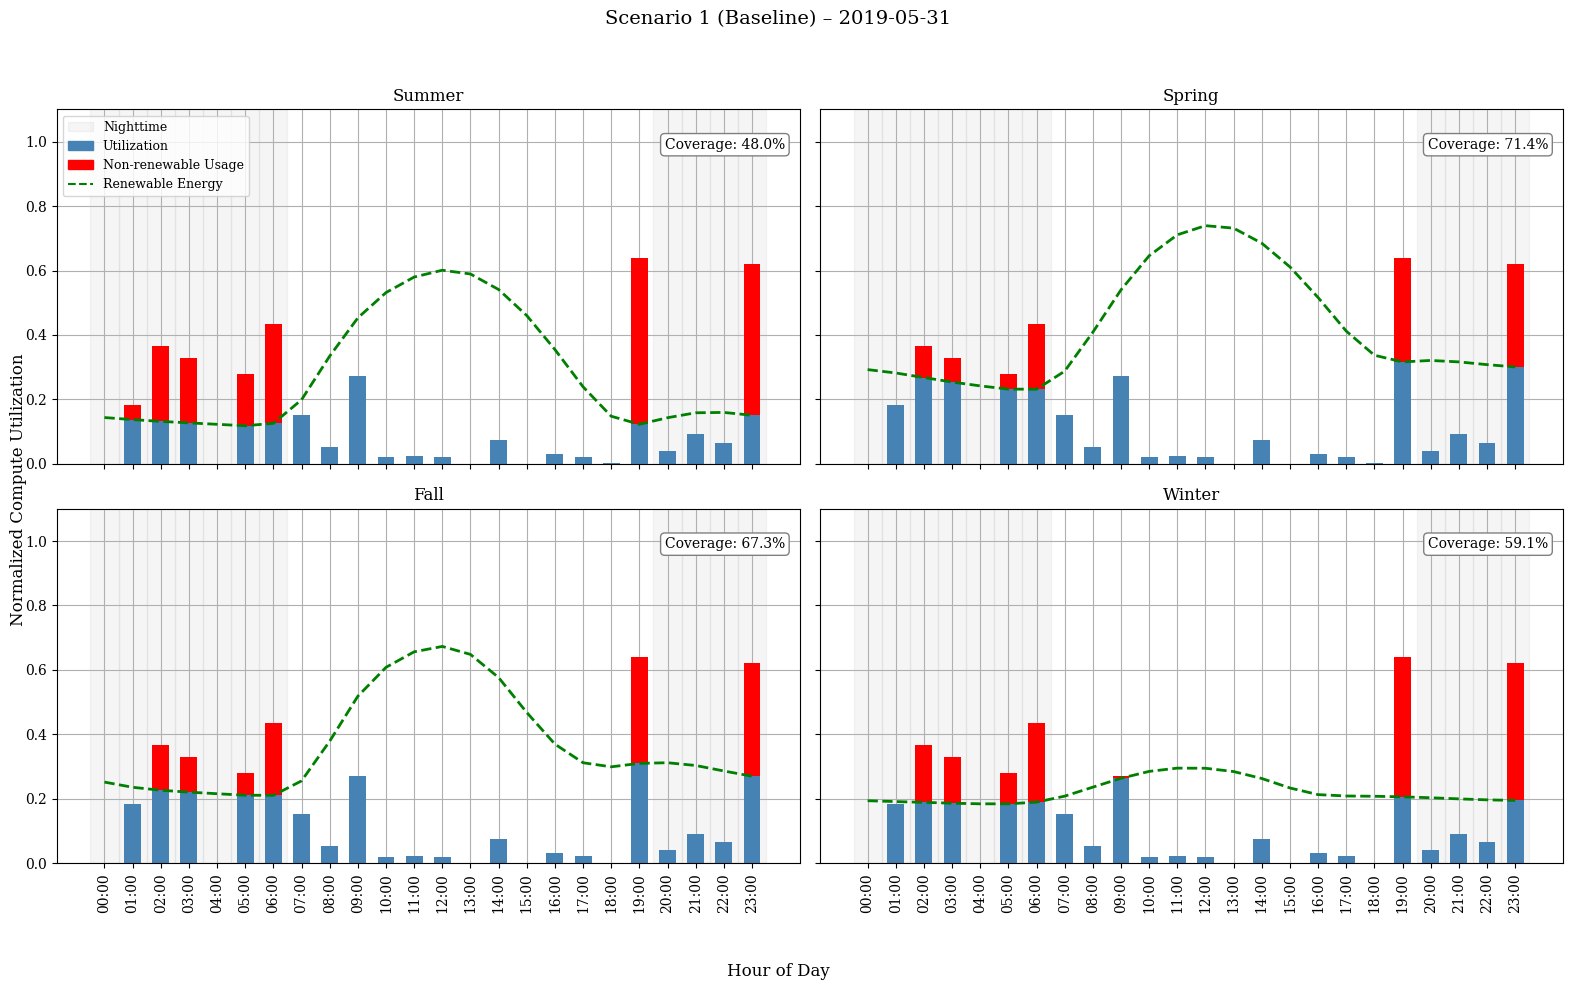

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Style === #
mpl.rcParams['font.family'] = 'serif'

# === Parameter === #
target_date = "2019-05-31"
traces_file = "sampled_2019-05-31.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5

# === Load traces once === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df["absolute_hour"] = df["start_datetime"].dt.hour
compute_per_hour = df.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)

# Normalisierung
normalized_util = compute_per_hour / global_max
x = np.arange(24)

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()

# === Farben und Legenden === #
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
]

# === Loop über Renewables-Files === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    normalized_renewable = renewable_scaled / global_max

    # Bars: blau (innerhalb), rot (überschuss)
    for hour in x:
        util_val = normalized_util[hour]
        renew_val = normalized_renewable[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.6, color="steelblue", zorder=2)
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.6, color="red", zorder=2)
        else:
            ax.bar(hour, util_val, width=0.6, color="steelblue", zorder=2)

    # Nachtstunden
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x, normalized_renewable, color='green', linestyle='--', linewidth=2, label='Renewable Energy', zorder=3)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{h:02d}:00" for h in x], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)

    # Coverage anzeigen
    coverage = np.minimum(normalized_util, normalized_renewable).sum() / normalized_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Achsenbeschriftungen
fig.suptitle(f"Scenario 1 (Baseline) – {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")

# Legende nur einmal
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_626/3205065065.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/3205065065.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/3205065065.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
/tmp/ipykernel_626/3205065065.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To e

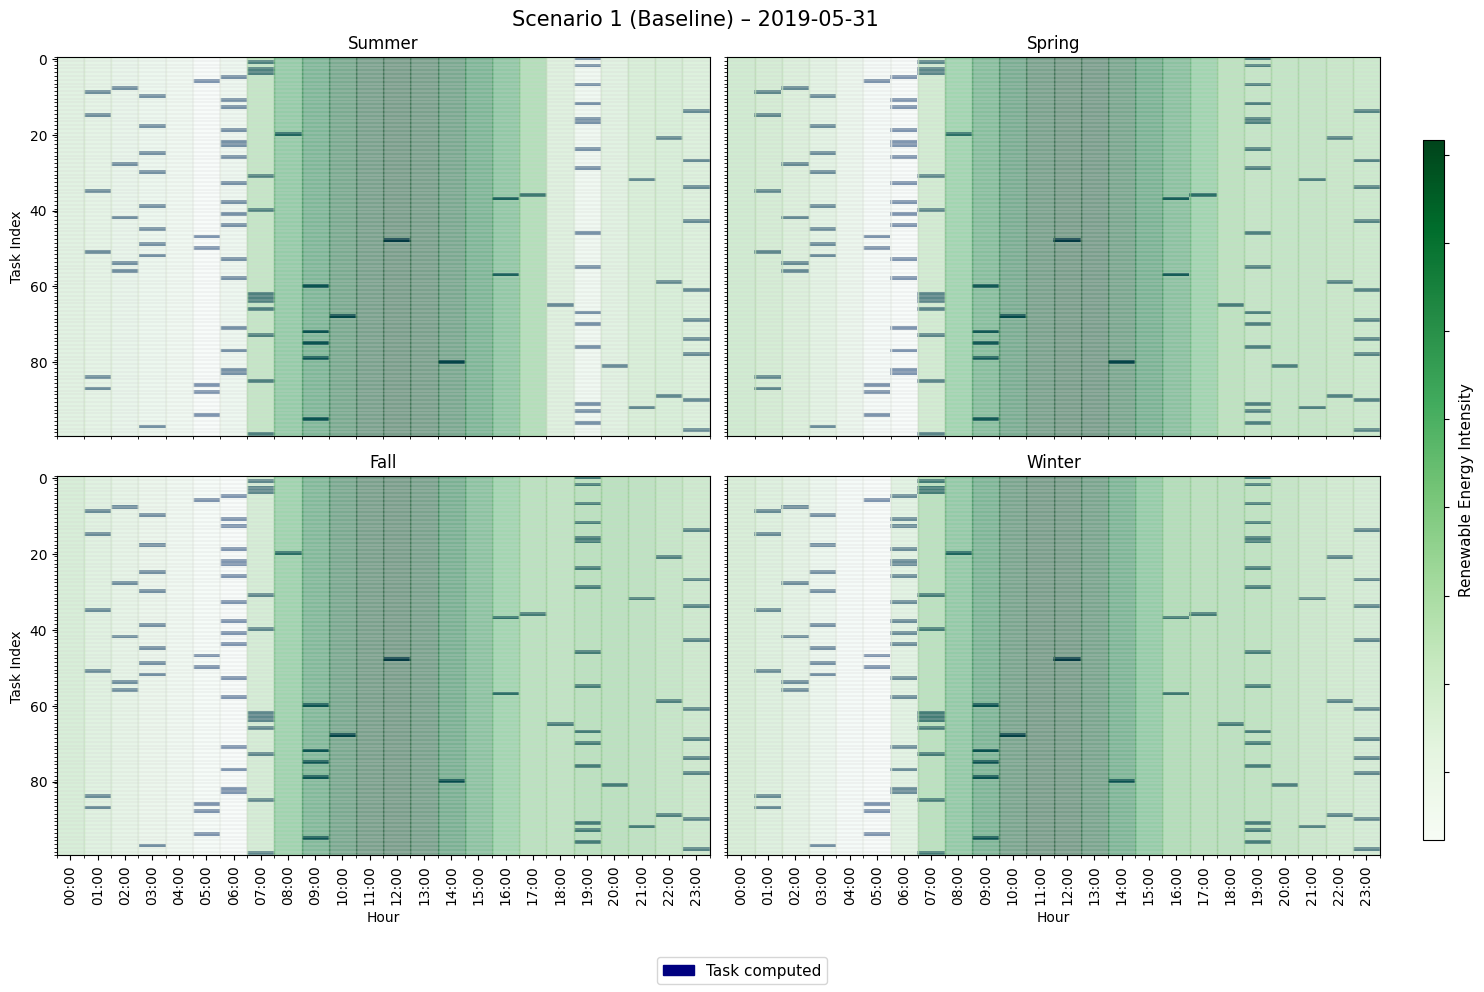

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# === Parameter === #
target_date = "2019-05-31"
trace_file = "sampled_2019-05-31.csv"
renewable_files = [
    ("Summer", "Renewables_Summer.csv"),
    ("Spring", "Renewables_Spring.csv"),
    ("Fall", "Renewables_Fall.csv"),
    ("Winter", "Renewables_Winter.csv")
]
scaling_factor = 1.5
gamma = 0.5  # for contrast

# === Load trace data === #
df = pd.read_csv(trace_file)
df["absolute_hour"] = df["start_datetime"].astype('datetime64[ns]').dt.hour

# === Sampling 100 tasks === #
counts = df["absolute_hour"].value_counts().sort_index()
proportions = counts / counts.sum()
task_counts = (proportions * 100).round().astype(int)

# Korrektur auf exakt 100 Tasks
delta = 100 - task_counts.sum()
adjustment_indices = task_counts.sort_values(ascending=(delta < 0)).index
for idx in adjustment_indices:
    task_counts[idx] += np.sign(delta)
    delta -= np.sign(delta)
    if delta == 0:
        break

# Sampling pro Stunde
df_sampled = pd.DataFrame()
for hour, n in task_counts.items():
    sampled = df[df["absolute_hour"] == hour].head(n)
    df_sampled = pd.concat([df_sampled, sampled])

df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# === Heatmap-Matrix vorbereiten === #
tasks = df_sampled.index.tolist()
time_slots = list(range(24))
heatmap_matrix = np.zeros((len(tasks), len(time_slots)))
for i, row in df_sampled.iterrows():
    hour = row["absolute_hour"]
    heatmap_matrix[i, hour] = 1

# === Plot (2x2 Grid) === #
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, (season, ren_file) in enumerate(renewable_files):
    ax = axs[idx]

    df_ren = pd.read_csv(ren_file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"])
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_hourly = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_hourly * scaling_factor
    renewable_norm = ((renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())) ** gamma
    renewable_colors = plt.cm.Greens(renewable_norm)

    # Hintergrundfärbung je Stunde
    for h in time_slots:
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # Binär-Matrix
    cax = ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenbeschriftung
    if idx in [2, 3]:
        ax.set_xlabel("Hour", fontsize=10)
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)], rotation=90)
    else:
        ax.set_xticks([])

    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])
        ax.set_ylabel("")
        
    # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)


    # Gitter
    ax.set_xticks(np.arange(-0.5, 24, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(tasks), 1), minor=True)
    ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.3)

# Legende und Colorbar
task_patch = mpatches.Patch(color='navy', label='Task computed')
fig.legend(handles=[task_patch], loc='lower center', ncol=4, fontsize=11)

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Platz für Colorbar außerhalb des gesamten Figure-Rahmens
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])  # [left, bottom, width, height]

norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=11)
cbar.ax.set_yticklabels([])  # Skalen entfernen



plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 1 (Baseline) – {target_date}", fontsize=15)
plt.show()


## Scenario 2

In [11]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 113.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Day 1: 2019-05-03 (2x2)

Solving MILP for Summer...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/58a2fe93952748fab8f4dc6face9f741-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/58a2fe93952748fab8f4dc6face9f741-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10823 COLUMNS
At line 127639 RHS
At line 138458 BOUNDS
At line 153699 ENDATA
Problem MODEL has 10818 rows, 15264 columns and 86311 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.796599 - 0.14 seconds
Cgl0002I 10087 variables fixed
Cgl0004I processed model has 591 rows, 5059 columns (5036 integer (5035 of which binary)) and 12442 elements
Cbc0038I Initial state - 27 integers unsatisfied sum - 5.60428
Cbc0038I Pass   1: suminf.    0.10184 (1) obj. 0.829252 iterations 203
Cbc0038I Solution found of

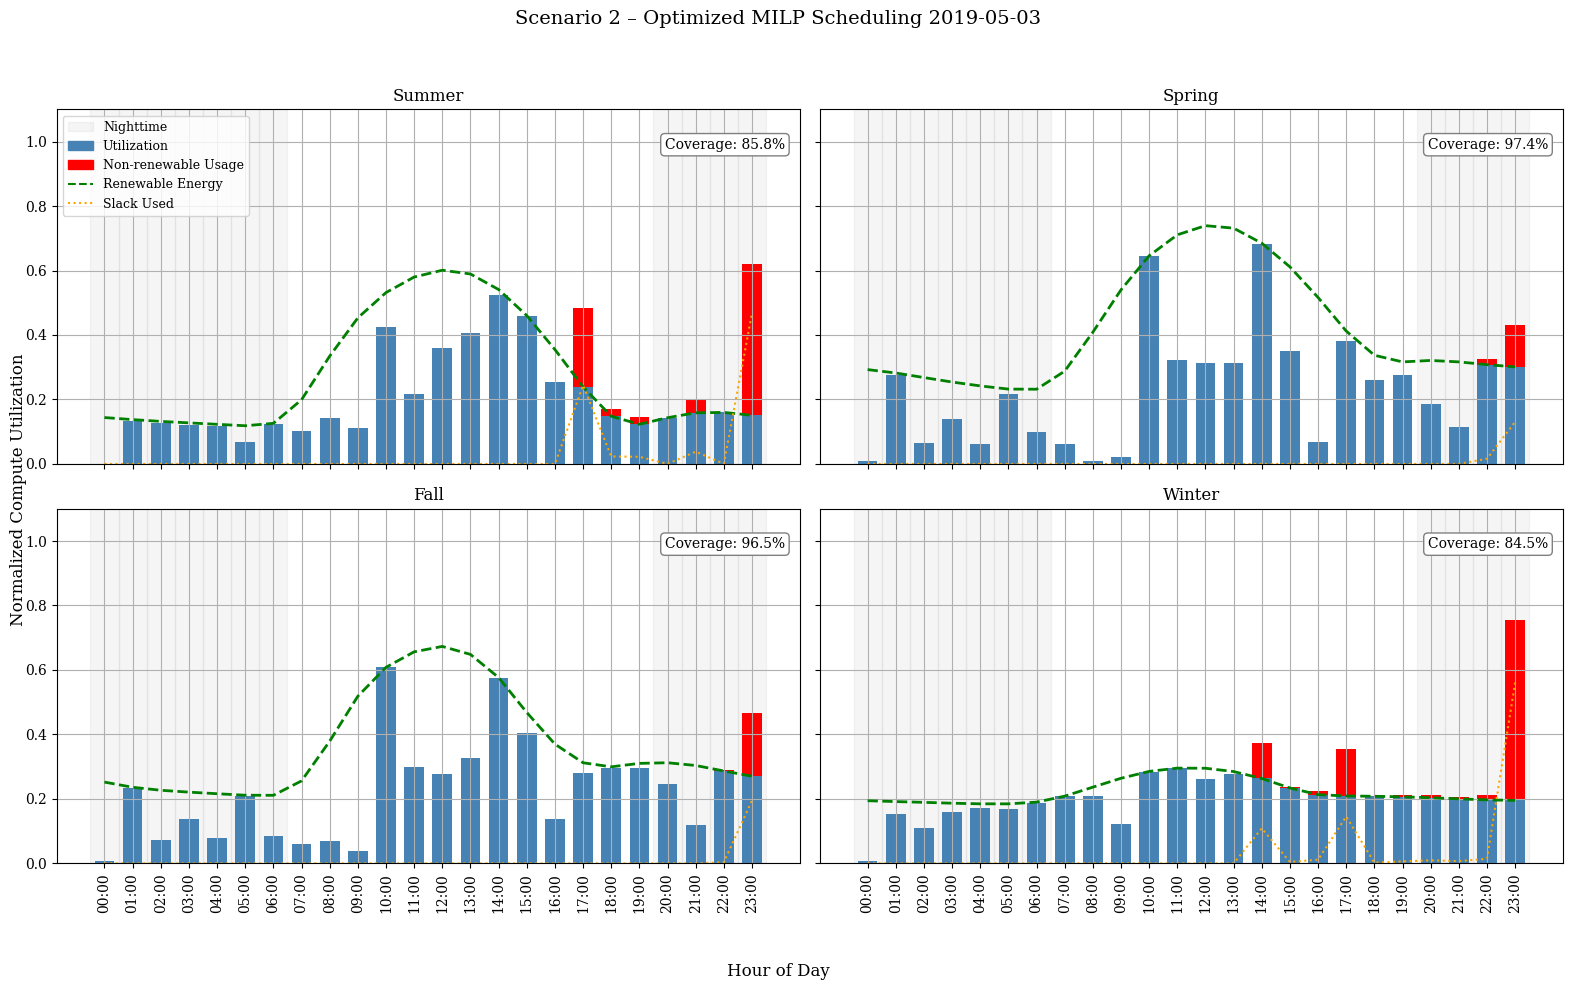

In [43]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Parameter === #
target_date = "2019-05-03"
traces_file = "sampled_2019-05-03.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5
T = list(range(24))
x_ticks = np.arange(24)

# === Load sampled traces === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df = df.reset_index(drop=True)
df["task_id"] = df.index
df["actual_utilization"] = df["compute_utilization"]
df["normalized_utilization"] = df["actual_utilization"] / global_max

# === MILP-Setup Shared === #
tasks = df["task_id"].tolist()
utilization = dict(zip(df.task_id, df["normalized_utilization"]))
flex_class = dict(zip(df.task_id, df["flexibility_class"]))
orig_hour = dict(zip(df.task_id, df["start_hour"]))
cpu_usage = dict(zip(df.task_id, df["used_cpu"]))
memory_usage = dict(zip(df.task_id, df["used_memory"]))
gpu_usage = dict(zip(df.task_id, df.get("estimated_gpu", pd.Series(0, index=df.index))))

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
    Line2D([0], [0], color='orange', linestyle=':', label='Slack Used'),
]

# === Loop über Jahreszeiten === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    # Renewables vorbereiten
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_hourly = renewable_scaled.to_dict()
    renewable_hourly_norm = {h: renewable_hourly[h] / global_max for h in range(24)}

    # MILP erstellen
    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    # Constraints
    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= renewable_hourly_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage[i] for i in tasks) <= 0.9

    # Lösen
    print(f"Solving MILP for {season}...")
    model.solve()
    print("Status:", pulp.LpStatus[model.status])

    # Ergebnisse extrahieren
    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    slack_used = pd.Series({t: pulp.value(slack[t]) for t in T})
    renewable_series = pd.Series(renewable_hourly_norm).reindex(T)

    # Plotting
    for hour in x_ticks:
        util_val = scheduled_util[hour]
        renew_val = renewable_series[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.7, color="steelblue")
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.7, color="red")
        else:
            ax.bar(hour, util_val, width=0.7, color="steelblue")
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x_ticks, renewable_series, color="green", linestyle="--", linewidth=2)
    ax.plot(x_ticks, slack_used, color="orange", linestyle=":", linewidth=1.5)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in x_ticks], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)

    # Coverage anzeigen
    coverage = np.minimum(scheduled_util, renewable_series).sum() / scheduled_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Titel und Legende
fig.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_94/2048517332.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.97])


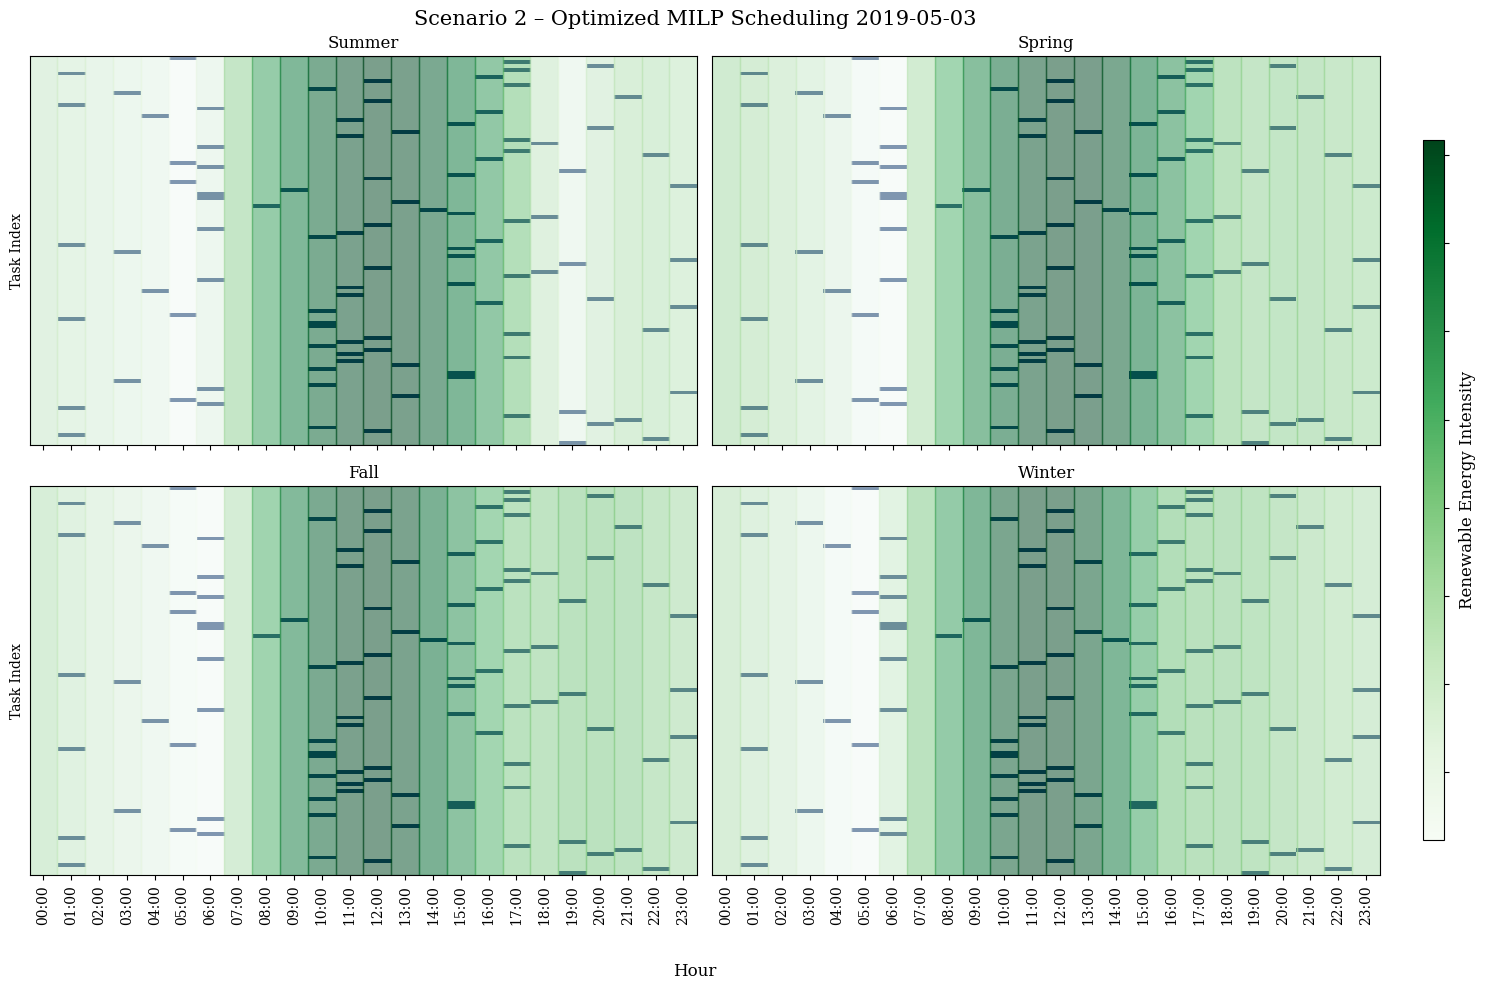

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

for idx, (ax, (season, file)) in enumerate(zip(axs, renewable_files.items())):
    # === Renewables vorbereiten ===
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_norm = (renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())
    renewable_norm = renewable_norm ** 0.5  # Gamma-Korrektur für Kontrast

    # === 100 Tasks aus result_df samplen ===
    df_sampled = result_df.sample(n=100, random_state=42).reset_index(drop=True)

    # === Heatmap-Matrix vorbereiten ===
    heatmap_matrix = np.zeros((100, 24))
    for i, row in df_sampled.iterrows():
        hour = int(row["scheduled_hour"])
        if 0 <= hour < 24:
            heatmap_matrix[i, hour] = 1

    # === Hintergrund: Renewables ===
    renewable_cmap = plt.cm.Greens
    renewable_colors = renewable_cmap(renewable_norm)

    for h in range(24):
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # === Task Heatmap ===
    ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)

    # Y-Achse nur links
    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])

    # X-Achse nur unten
    if idx in [2, 3]:
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=90)
    else:
        ax.set_xticks([])

# Colorbar ganz rechts
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])
norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=12)
cbar.ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=15)
fig.supxlabel("Hour")
plt.show()


#### Day 2: 2019-05-27 (2x2)

Solving MILP for Summer...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/9d7a783058ea4dd08228b4e3ee902d41-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/9d7a783058ea4dd08228b4e3ee902d41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6960 COLUMNS
At line 72151 RHS
At line 79107 BOUNDS
At line 87484 ENDATA
Problem MODEL has 6955 rows, 8400 columns and 48414 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0002I 6510 variables fixed
Cgl0004I processed model has 334 rows, 1823 columns (1805 integer (1805 of which binary)) and 4314 elements
Cbc0038I Initial state - 17 integers unsatisfied sum - 4.94755
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 0.0698167 iterations 16
Cbc0038I Solution found of 0.0698167
Cbc0

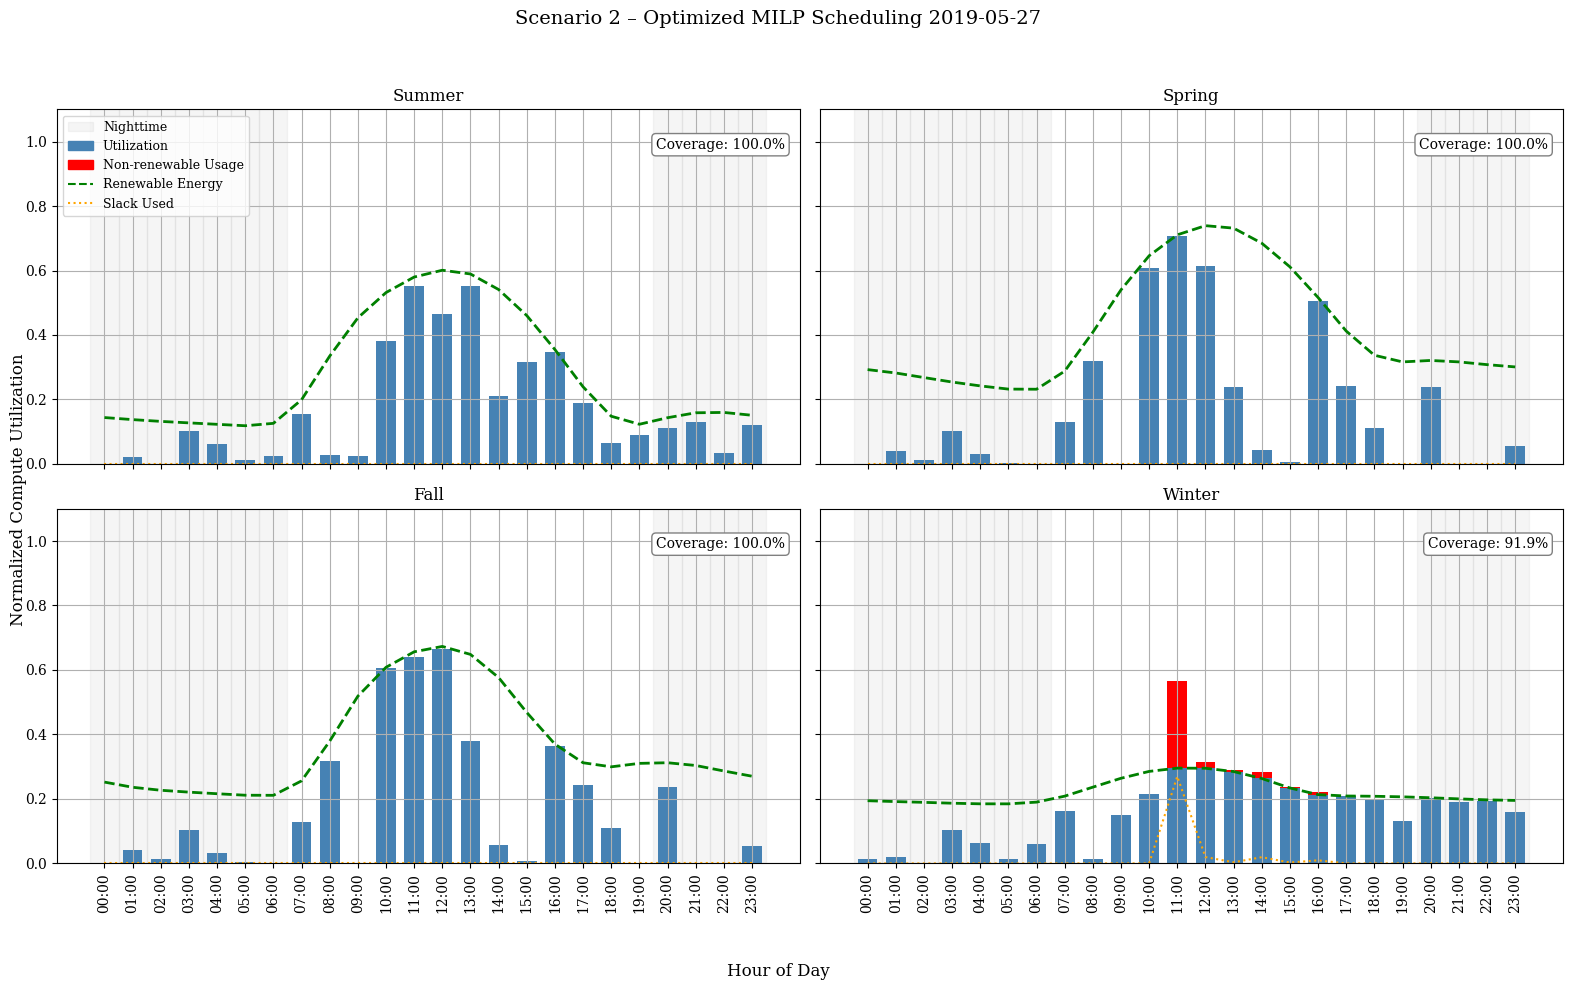

In [53]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Parameter === #
target_date = "2019-05-27"
traces_file = "sampled_2019-05-27.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5
T = list(range(24))
x_ticks = np.arange(24)

# === Load sampled traces === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df = df.reset_index(drop=True)
df["task_id"] = df.index
df["actual_utilization"] = df["compute_utilization"]
df["normalized_utilization"] = df["actual_utilization"] / global_max

# === MILP-Setup Shared === #
tasks = df["task_id"].tolist()
utilization = dict(zip(df.task_id, df["normalized_utilization"]))
flex_class = dict(zip(df.task_id, df["flexibility_class"]))
orig_hour = dict(zip(df.task_id, df["start_hour"]))
cpu_usage = dict(zip(df.task_id, df["used_cpu"]))
memory_usage = dict(zip(df.task_id, df["used_memory"]))
gpu_usage = dict(zip(df.task_id, df.get("estimated_gpu", pd.Series(0, index=df.index))))

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
    Line2D([0], [0], color='orange', linestyle=':', label='Slack Used'),
]

# === Loop über Jahreszeiten === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    # Renewables vorbereiten
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_hourly = renewable_scaled.to_dict()
    renewable_hourly_norm = {h: renewable_hourly[h] / global_max for h in range(24)}

    # MILP erstellen
    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    # Constraints
    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= renewable_hourly_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage[i] for i in tasks) <= 0.9

    # Lösen
    print(f"Solving MILP for {season}...")
    model.solve()
    print("Status:", pulp.LpStatus[model.status])

    # Ergebnisse extrahieren
    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    slack_used = pd.Series({t: pulp.value(slack[t]) for t in T})
    renewable_series = pd.Series(renewable_hourly_norm).reindex(T)

    # Plotting
    for hour in x_ticks:
        util_val = scheduled_util[hour]
        renew_val = renewable_series[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.7, color="steelblue")
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.7, color="red")
        else:
            ax.bar(hour, util_val, width=0.7, color="steelblue")
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x_ticks, renewable_series, color="green", linestyle="--", linewidth=2)
    ax.plot(x_ticks, slack_used, color="orange", linestyle=":", linewidth=1.5)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in x_ticks], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)

    # Coverage anzeigen
    coverage = np.minimum(scheduled_util, renewable_series).sum() / scheduled_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Titel und Legende
fig.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_94/2048517332.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.97])


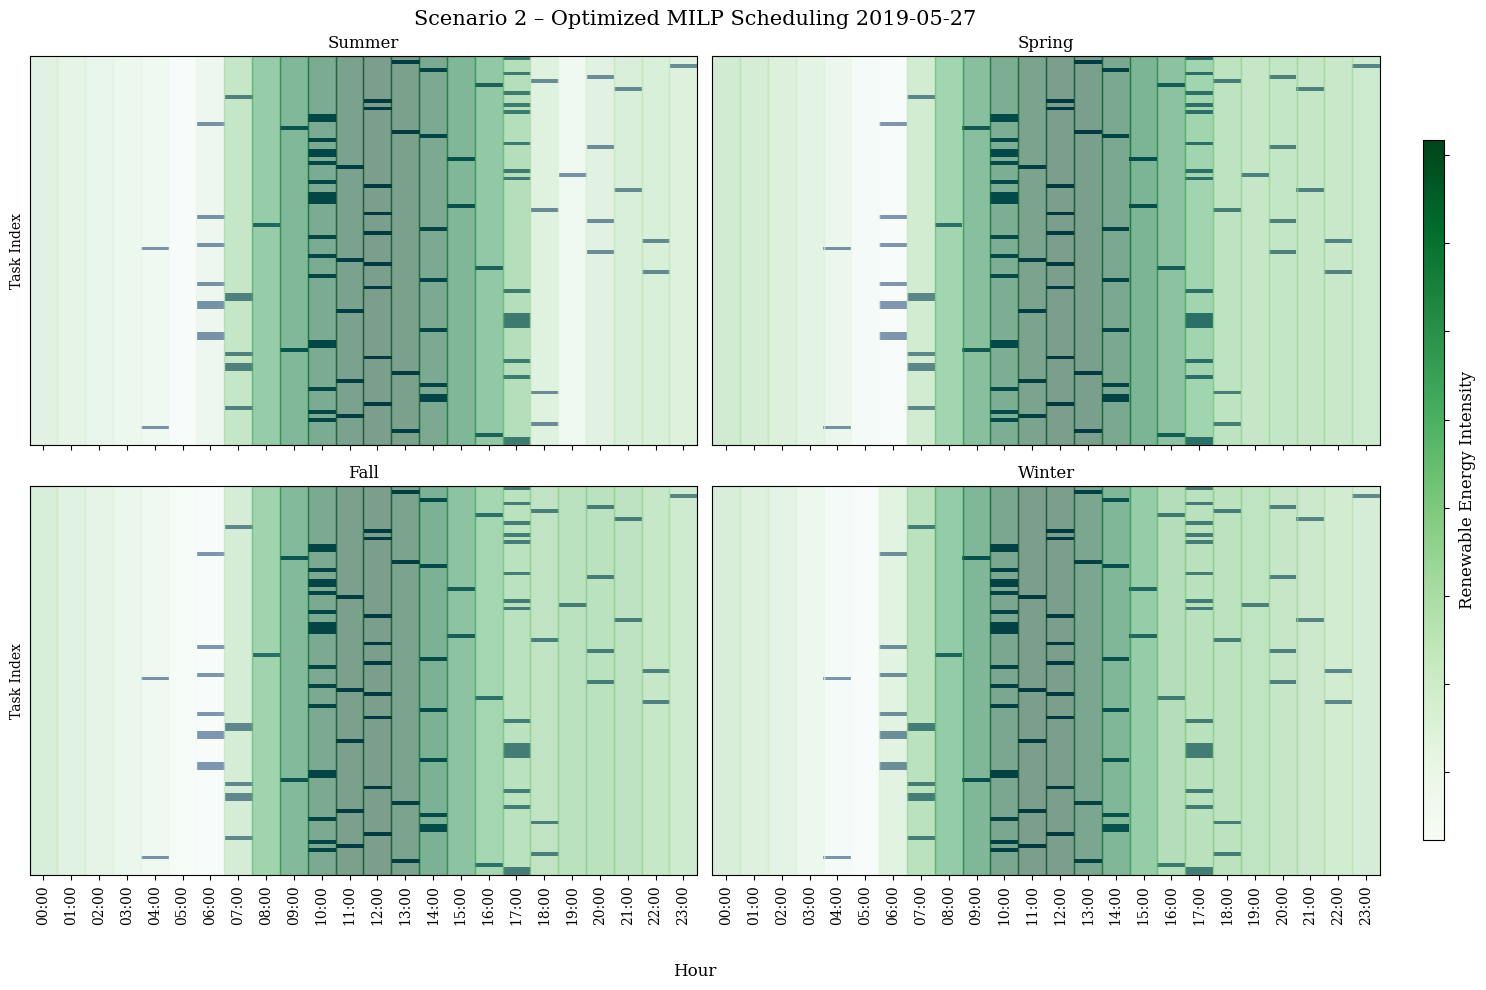

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

for idx, (ax, (season, file)) in enumerate(zip(axs, renewable_files.items())):
    # === Renewables vorbereiten ===
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_norm = (renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())
    renewable_norm = renewable_norm ** 0.5  # Gamma-Korrektur für Kontrast

    # === 100 Tasks aus result_df samplen ===
    df_sampled = result_df.sample(n=100, random_state=42).reset_index(drop=True)

    # === Heatmap-Matrix vorbereiten ===
    heatmap_matrix = np.zeros((100, 24))
    for i, row in df_sampled.iterrows():
        hour = int(row["scheduled_hour"])
        if 0 <= hour < 24:
            heatmap_matrix[i, hour] = 1

    # === Hintergrund: Renewables ===
    renewable_cmap = plt.cm.Greens
    renewable_colors = renewable_cmap(renewable_norm)

    for h in range(24):
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # === Task Heatmap ===
    ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)

    # Y-Achse nur links
    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])

    # X-Achse nur unten
    if idx in [2, 3]:
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=90)
    else:
        ax.set_xticks([])

# Colorbar ganz rechts
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])
norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=12)
cbar.ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=15)
fig.supxlabel("Hour")
plt.show()


Solving MILP for Summer...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/136de51d3b77464ba1a9669454a112fd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/136de51d3b77464ba1a9669454a112fd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3503 COLUMNS
At line 38016 RHS
At line 41515 BOUNDS
At line 45980 ENDATA
Problem MODEL has 3498 rows, 4488 columns and 25560 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.747704 - 0.01 seconds
Cgl0002I 3216 variables fixed
Cgl0004I processed model has 150 rows, 1212 columns (1189 integer (1189 of which binary)) and 2401 elements
Cbc0038I Initial state - 12 integers unsatisfied sum - 1.6084
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 0.757474 iterations 12
Cbc0038I Solution found of 0.757474


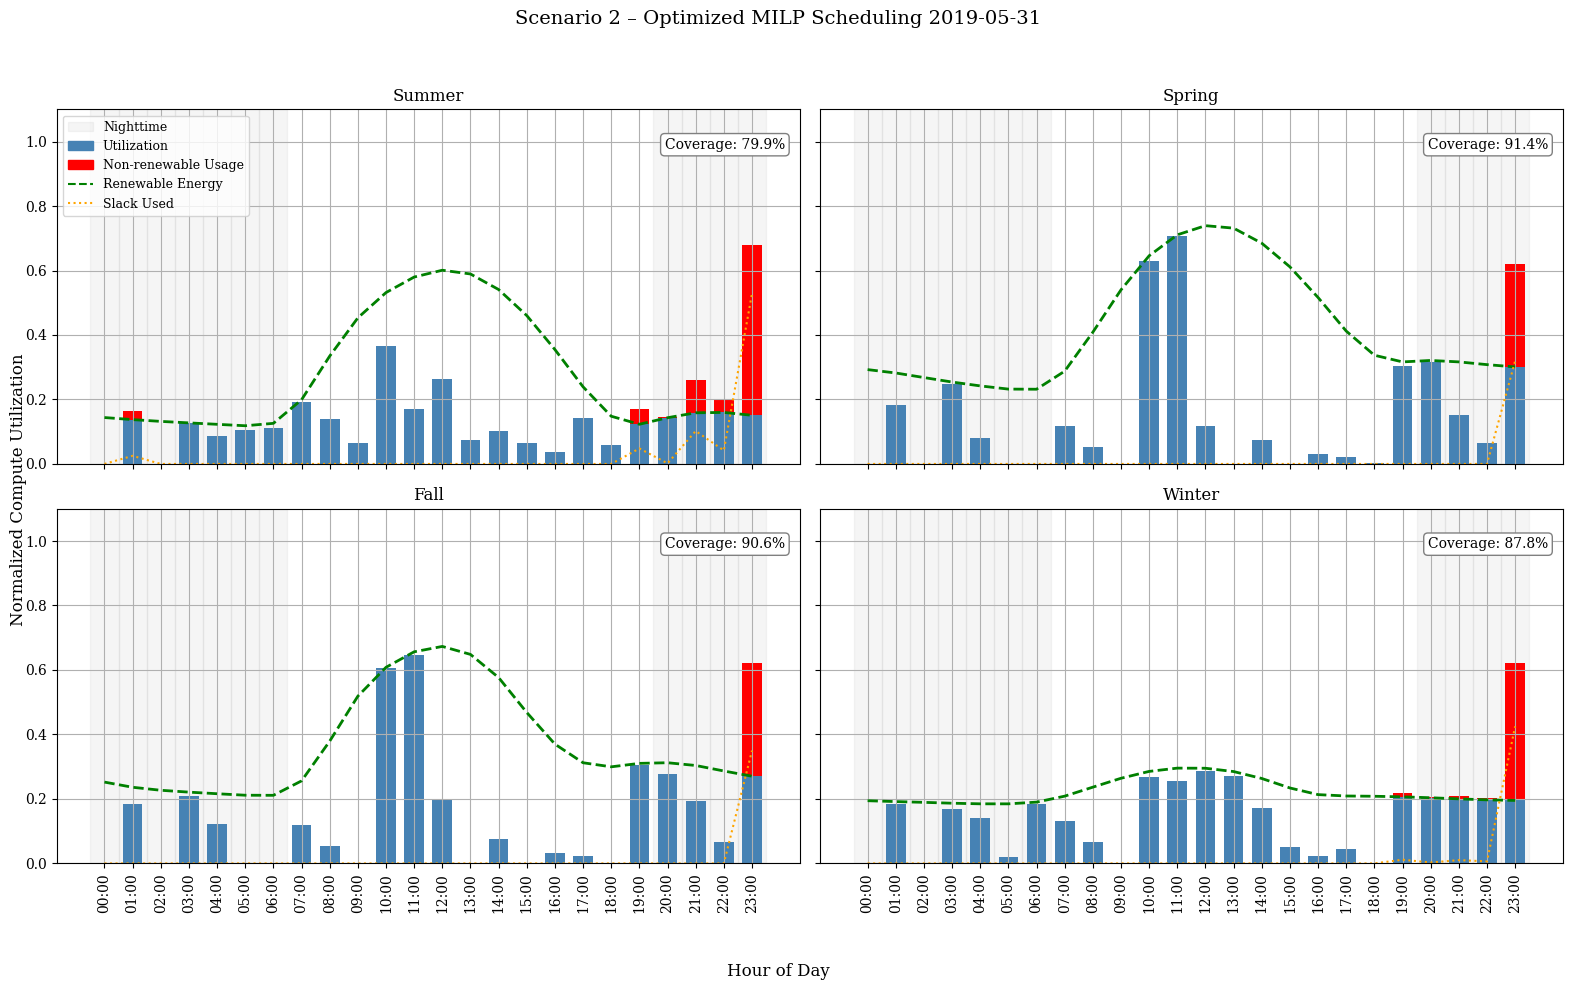

In [55]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# === Parameter === #
target_date = "2019-05-31"
traces_file = "sampled_2019-05-31.csv"
renewable_files = {
    "Summer": "Renewables_Summer.csv",
    "Spring": "Renewables_Spring.csv",
    "Fall": "Renewables_Fall.csv",
    "Winter": "Renewables_Winter.csv"
}
scaling_factor = 1.5
T = list(range(24))
x_ticks = np.arange(24)

# === Load sampled traces === #
df = pd.read_csv(traces_file, parse_dates=["start_datetime"])
df["start_hour"] = df["start_datetime"].dt.hour
df = df.reset_index(drop=True)
df["task_id"] = df.index
df["actual_utilization"] = df["compute_utilization"]
df["normalized_utilization"] = df["actual_utilization"] / global_max

# === MILP-Setup Shared === #
tasks = df["task_id"].tolist()
utilization = dict(zip(df.task_id, df["normalized_utilization"]))
flex_class = dict(zip(df.task_id, df["flexibility_class"]))
orig_hour = dict(zip(df.task_id, df["start_hour"]))
cpu_usage = dict(zip(df.task_id, df["used_cpu"]))
memory_usage = dict(zip(df.task_id, df["used_memory"]))
gpu_usage = dict(zip(df.task_id, df.get("estimated_gpu", pd.Series(0, index=df.index))))

# === Plot Setup === #
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axs = axs.flatten()
night_hours = list(range(0, 7)) + list(range(20, 24))
legend_elements = [
    mpatches.Patch(color='gray', alpha=0.08, label='Nighttime'),
    mpatches.Patch(color='steelblue', label='Utilization'),
    mpatches.Patch(color='red', label='Non-renewable Usage'),
    Line2D([0], [0], color='green', linestyle='--', label='Renewable Energy'),
    Line2D([0], [0], color='orange', linestyle=':', label='Slack Used'),
]

# === Loop über Jahreszeiten === #
for ax, (season, file) in zip(axs, renewable_files.items()):
    # Renewables vorbereiten
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_hourly = renewable_scaled.to_dict()
    renewable_hourly_norm = {h: renewable_hourly[h] / global_max for h in range(24)}

    # MILP erstellen
    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    # Constraints
    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= renewable_hourly_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage[i] for i in tasks) <= 0.9

    # Lösen
    print(f"Solving MILP for {season}...")
    model.solve()
    print("Status:", pulp.LpStatus[model.status])

    # Ergebnisse extrahieren
    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    slack_used = pd.Series({t: pulp.value(slack[t]) for t in T})
    renewable_series = pd.Series(renewable_hourly_norm).reindex(T)

    # Plotting
    for hour in x_ticks:
        util_val = scheduled_util[hour]
        renew_val = renewable_series[hour]
        if util_val > renew_val:
            ax.bar(hour, renew_val, width=0.7, color="steelblue")
            ax.bar(hour, util_val - renew_val, bottom=renew_val, width=0.7, color="red")
        else:
            ax.bar(hour, util_val, width=0.7, color="steelblue")
    for nh in night_hours:
        ax.axvspan(nh - 0.5, nh + 0.5, color='gray', alpha=0.08, zorder=0)

    ax.plot(x_ticks, renewable_series, color="green", linestyle="--", linewidth=2)
    ax.plot(x_ticks, slack_used, color="orange", linestyle=":", linewidth=1.5)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in x_ticks], rotation=90)
    ax.set_ylim(0, 1.1)
    ax.grid(True)

    # Coverage anzeigen
    coverage = np.minimum(scheduled_util, renewable_series).sum() / scheduled_util.sum()
    ax.text(0.98, 0.92, f"Coverage: {coverage:.1%}", transform=ax.transAxes,
            fontsize=10, ha='right', va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

# Gemeinsame Titel und Legende
fig.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=14)
fig.supxlabel("Hour of Day")
fig.supylabel("Normalized Compute Utilization")
axs[0].legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_94/2048517332.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.97])


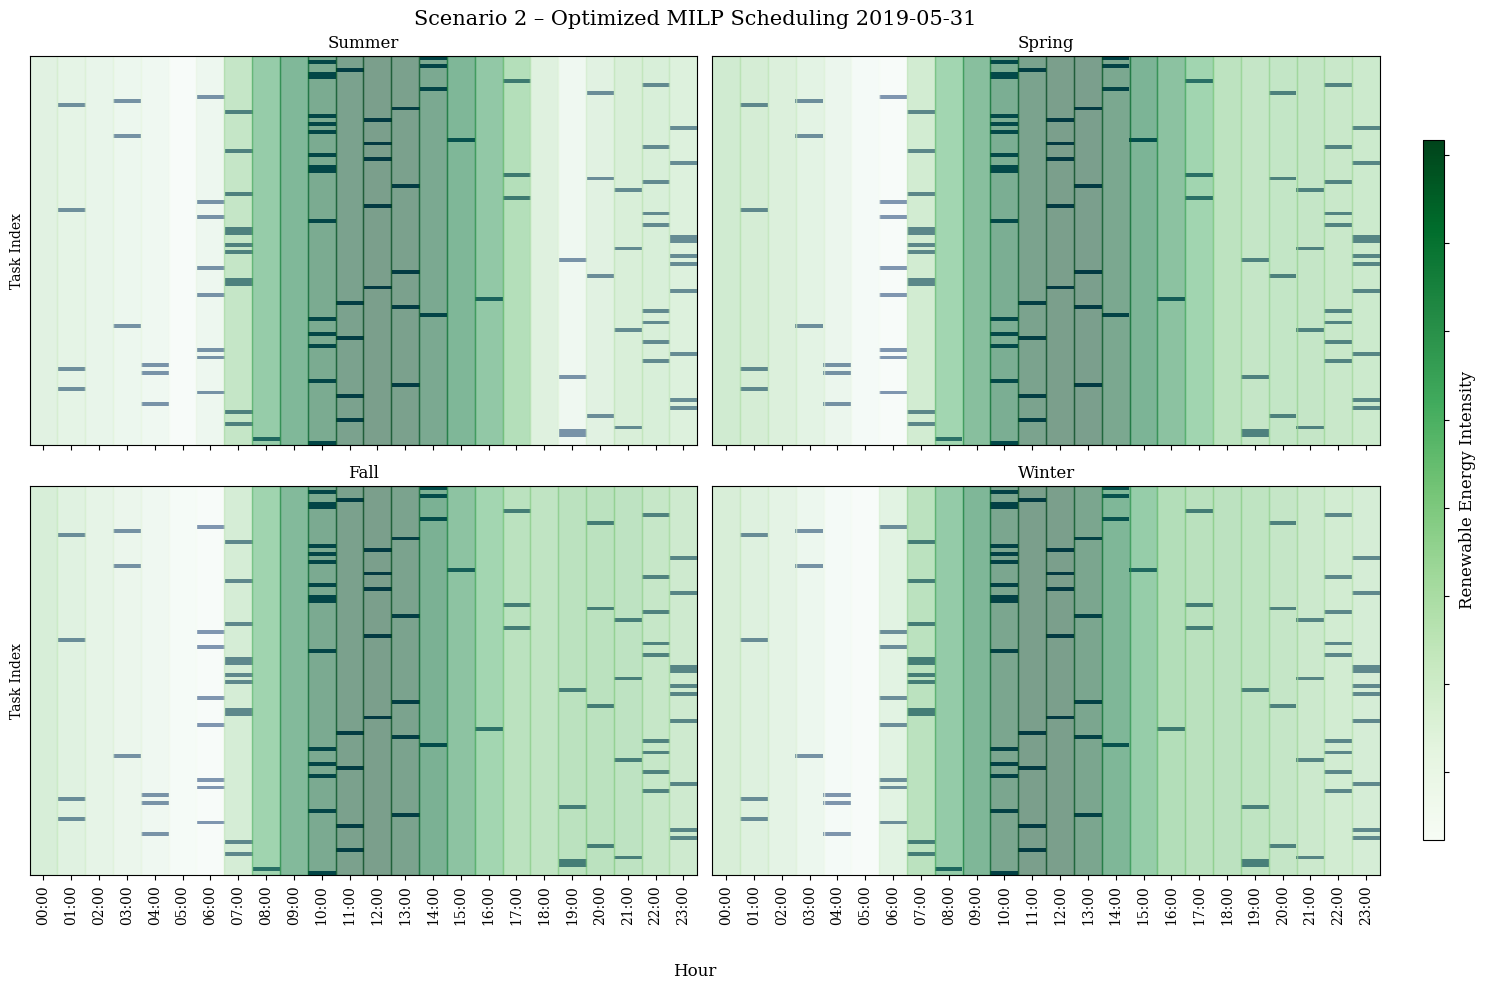

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axs = axs.flatten()

for idx, (ax, (season, file)) in enumerate(zip(axs, renewable_files.items())):
    # === Renewables vorbereiten ===
    df_ren = pd.read_csv(file)
    df_ren["local_time"] = pd.to_datetime(df_ren["local_time"], format="%H:%M:%S")
    df_ren["hour"] = df_ren["local_time"].dt.hour
    renewable_raw = df_ren.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renewable_scaled = renewable_raw * scaling_factor
    renewable_norm = (renewable_scaled - renewable_scaled.min()) / (renewable_scaled.max() - renewable_scaled.min())
    renewable_norm = renewable_norm ** 0.5  # Gamma-Korrektur für Kontrast

    # === 100 Tasks aus result_df samplen ===
    df_sampled = result_df.sample(n=100, random_state=42).reset_index(drop=True)

    # === Heatmap-Matrix vorbereiten ===
    heatmap_matrix = np.zeros((100, 24))
    for i, row in df_sampled.iterrows():
        hour = int(row["scheduled_hour"])
        if 0 <= hour < 24:
            heatmap_matrix[i, hour] = 1

    # === Hintergrund: Renewables ===
    renewable_cmap = plt.cm.Greens
    renewable_colors = renewable_cmap(renewable_norm)

    for h in range(24):
        ax.axvspan(h - 0.5, h + 0.5, color=renewable_colors[h], alpha=0.5)

    # === Task Heatmap ===
    ax.imshow(heatmap_matrix, aspect='auto', cmap='Blues', interpolation='none')

    # Achsenformatierung
    ax.set_title(f"{season}", fontsize=12)

    # Y-Achse nur links
    if idx in [0, 2]:
        ax.set_ylabel("Task Index", fontsize=10)
    else:
        ax.set_yticks([])

    # X-Achse nur unten
    if idx in [2, 3]:
        ax.set_xticks(np.arange(0, 24, 1))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(24)], rotation=90)
    else:
        ax.set_xticks([])

# Colorbar ganz rechts
cbar_ax = fig.add_axes([1.02, 0.15, 0.015, 0.7])
norm = Normalize(vmin=renewable_scaled.min(), vmax=renewable_scaled.max())
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Renewable Energy Intensity", fontsize=12)
cbar.ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.suptitle(f"Scenario 2 – Optimized MILP Scheduling {target_date}", fontsize=15)
fig.supxlabel("Hour")
plt.show()


## Yearly Analysis

#### Scenario 1

In [17]:
import pandas as pd
import numpy as np

# === Parameter ===
trace_file = "sampled_2019-05-03.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5

# === Load trace data ===
df_trace = pd.read_csv(trace_file, parse_dates=["start_datetime"])
df_trace["absolute_hour"] = df_trace["start_datetime"].dt.hour
df_trace["start_date"] = df_trace["start_datetime"].dt.date
target_date = df_trace["start_date"].iloc[0]

# === Global Max berechnen ===
compute_per_hour = df_trace.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)
global_max = compute_per_hour.max()

# === Normalisierte Tageskurve ===
normalized_util = compute_per_hour / global_max

# === Load renewables ===
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Tagesweise Coverage berechnen ===
daily_coverage = []

for day, group in df_ren.groupby("date"):
    renew_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renew_scaled = (renew_hourly * scaling_factor) / global_max
    coverage = np.minimum(normalized_util, renew_scaled).sum() / normalized_util.sum()
    daily_coverage.append({"date": day, "coverage": coverage})

# === In DataFrame umwandeln ===
df_coverage = pd.DataFrame(daily_coverage)
df_coverage.to_csv("coverage_scenario1_2019-05-03.csv", index=False)



In [14]:
import pandas as pd
import numpy as np

# === Parameter ===
trace_file = "sampled_2019-05-27.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5

# === Load trace data ===
df_trace = pd.read_csv(trace_file, parse_dates=["start_datetime"])
df_trace["absolute_hour"] = df_trace["start_datetime"].dt.hour
df_trace["start_date"] = df_trace["start_datetime"].dt.date
target_date = df_trace["start_date"].iloc[0]

# === Global Max berechnen ===
compute_per_hour = df_trace.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)
global_max = compute_per_hour.max()

# === Normalisierte Tageskurve ===
normalized_util = compute_per_hour / global_max

# === Load renewables ===
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Tagesweise Coverage berechnen ===
daily_coverage = []

for day, group in df_ren.groupby("date"):
    renew_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renew_scaled = (renew_hourly * scaling_factor) / global_max
    coverage = np.minimum(normalized_util, renew_scaled).sum() / normalized_util.sum()
    daily_coverage.append({"date": day, "coverage": coverage})

# === In DataFrame umwandeln ===
df_coverage = pd.DataFrame(daily_coverage)
df_coverage.to_csv("coverage_scenario1_2019-05-27.csv", index=False)


In [15]:
import pandas as pd
import numpy as np

# === Parameter ===
trace_file = "sampled_2019-05-31.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5

# === Load trace data ===
df_trace = pd.read_csv(trace_file, parse_dates=["start_datetime"])
df_trace["absolute_hour"] = df_trace["start_datetime"].dt.hour
df_trace["start_date"] = df_trace["start_datetime"].dt.date
target_date = df_trace["start_date"].iloc[0]

# === Global Max berechnen ===
compute_per_hour = df_trace.groupby("absolute_hour")["compute_utilization"].sum().reindex(range(24), fill_value=0)
global_max = compute_per_hour.max()

# === Normalisierte Tageskurve ===
normalized_util = compute_per_hour / global_max

# === Load renewables ===
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Tagesweise Coverage berechnen ===
daily_coverage = []

for day, group in df_ren.groupby("date"):
    renew_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(range(24), fill_value=0)
    renew_scaled = (renew_hourly * scaling_factor) / global_max
    coverage = np.minimum(normalized_util, renew_scaled).sum() / normalized_util.sum()
    daily_coverage.append({"date": day, "coverage": coverage})

# === In DataFrame umwandeln ===
df_coverage = pd.DataFrame(daily_coverage)
df_coverage.to_csv("coverage_scenario1_2019-05-31.csv", index=False)


#### Scenario 2

In [22]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import pulp
from datetime import datetime

# === Parameter === #
task_file = "sampled_2019-05-03.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5
T = list(range(24))

# === Load traces === #
df_tasks = pd.read_csv(task_file, parse_dates=["start_datetime"])
df_tasks["start_hour"] = df_tasks["start_datetime"].dt.hour
df_tasks = df_tasks.reset_index(drop=True)
df_tasks["task_id"] = df_tasks.index
df_tasks["actual_utilization"] = df_tasks["compute_utilization"]
df_tasks["normalized_utilization"] = df_tasks["actual_utilization"] / global_max

# === Load renewables === #
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Ergebnisliste === #
results = []

# === Iterate over all days in year === #
for day, group in df_ren.groupby("date"):
    if len(group["hour"].unique()) < 24:
        print(f"Skipping {day} – not 24h data")
        continue

    ren_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(T, fill_value=0)
    ren_scaled = ren_hourly * scaling_factor
    ren_norm = (ren_scaled / global_max).to_dict()

    utilization = dict(zip(df_tasks.task_id, df_tasks["normalized_utilization"]))
    flex_class = dict(zip(df_tasks.task_id, df_tasks["flexibility_class"]))
    orig_hour = dict(zip(df_tasks.task_id, df_tasks["start_hour"]))
    cpu_usage = dict(zip(df_tasks.task_id, df_tasks["used_cpu"]))
    memory_usage = dict(zip(df_tasks.task_id, df_tasks["used_memory"]))
    gpu_usage = dict(zip(df_tasks.task_id, df_tasks.get("estimated_gpu", pd.Series(0, index=df_tasks.index))))

    tasks = df_tasks["task_id"].tolist()

    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= ren_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage.get(i, 0) for i in tasks) <= 0.9

    print(f"🔄 Solving MILP for {day}...")
    status = model.solve(pulp.PULP_CBC_CMD(msg=True, timeLimit=60))

    if status != 1:  # Not Optimal
        print(f"⚠️  No optimal solution found for {day} (Status: {pulp.LpStatus[status]})")
        continue

    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df_tasks.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    ren_series = pd.Series(ren_norm).reindex(T)
    coverage = np.minimum(scheduled_util, ren_series).sum() / scheduled_util.sum()

    results.append({"date": day, "coverage": coverage})
    print(f"✅ {day}: Coverage = {coverage:.2%}")

# === Save results === #
df_results = pd.DataFrame(results)
df_results.to_csv("coverage_scenario2_2019-05-03.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import pulp
from datetime import datetime

# === Parameter === #
task_file = "sampled_2019-05-27.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5
T = list(range(24))

# === Load traces === #
df_tasks = pd.read_csv(task_file, parse_dates=["start_datetime"])
df_tasks["start_hour"] = df_tasks["start_datetime"].dt.hour
df_tasks = df_tasks.reset_index(drop=True)
df_tasks["task_id"] = df_tasks.index
df_tasks["actual_utilization"] = df_tasks["compute_utilization"]
df_tasks["normalized_utilization"] = df_tasks["actual_utilization"] / global_max

# === Load renewables === #
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Ergebnisliste === #
results = []

# === Iterate over all days in year === #
for day, group in df_ren.groupby("date"):
    if len(group["hour"].unique()) < 24:
        print(f"Skipping {day} – not 24h data")
        continue

    ren_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(T, fill_value=0)
    ren_scaled = ren_hourly * scaling_factor
    ren_norm = (ren_scaled / global_max).to_dict()

    utilization = dict(zip(df_tasks.task_id, df_tasks["normalized_utilization"]))
    flex_class = dict(zip(df_tasks.task_id, df_tasks["flexibility_class"]))
    orig_hour = dict(zip(df_tasks.task_id, df_tasks["start_hour"]))
    cpu_usage = dict(zip(df_tasks.task_id, df_tasks["used_cpu"]))
    memory_usage = dict(zip(df_tasks.task_id, df_tasks["used_memory"]))
    gpu_usage = dict(zip(df_tasks.task_id, df_tasks.get("estimated_gpu", pd.Series(0, index=df_tasks.index))))

    tasks = df_tasks["task_id"].tolist()

    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= ren_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage.get(i, 0) for i in tasks) <= 0.9

    print(f"🔄 Solving MILP for {day}...")
    status = model.solve(pulp.PULP_CBC_CMD(msg=True, timeLimit=60))

    if status != 1:  # Not Optimal
        print(f"⚠️  No optimal solution found for {day} (Status: {pulp.LpStatus[status]})")
        continue

    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df_tasks.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    ren_series = pd.Series(ren_norm).reindex(T)
    coverage = np.minimum(scheduled_util, ren_series).sum() / scheduled_util.sum()

    results.append({"date": day, "coverage": coverage})
    print(f"✅ {day}: Coverage = {coverage:.2%}")

# === Save results === #
df_results = pd.DataFrame(results)
df_results.to_csv("coverage_scenario2_2019-05-27.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import pulp
from datetime import datetime

# === Parameter === #
task_file = "sampled_2019-05-31.csv"
renewables_file = "Renewables_2019.csv"
scaling_factor = 1.5
T = list(range(24))

# === Load traces === #
df_tasks = pd.read_csv(task_file, parse_dates=["start_datetime"])
df_tasks["start_hour"] = df_tasks["start_datetime"].dt.hour
df_tasks = df_tasks.reset_index(drop=True)
df_tasks["task_id"] = df_tasks.index
df_tasks["actual_utilization"] = df_tasks["compute_utilization"]
df_tasks["normalized_utilization"] = df_tasks["actual_utilization"] / global_max

# === Load renewables === #
df_ren = pd.read_csv(renewables_file, parse_dates=["local_time"])
df_ren["date"] = df_ren["local_time"].dt.date
df_ren["hour"] = df_ren["local_time"].dt.hour

# === Ergebnisliste === #
results = []

# === Iterate over all days in year === #
for day, group in df_ren.groupby("date"):
    if len(group["hour"].unique()) < 24:
        print(f"Skipping {day} – not 24h data")
        continue

    ren_hourly = group.groupby("hour")["total_renewable_energy"].mean().reindex(T, fill_value=0)
    ren_scaled = ren_hourly * scaling_factor
    ren_norm = (ren_scaled / global_max).to_dict()

    utilization = dict(zip(df_tasks.task_id, df_tasks["normalized_utilization"]))
    flex_class = dict(zip(df_tasks.task_id, df_tasks["flexibility_class"]))
    orig_hour = dict(zip(df_tasks.task_id, df_tasks["start_hour"]))
    cpu_usage = dict(zip(df_tasks.task_id, df_tasks["used_cpu"]))
    memory_usage = dict(zip(df_tasks.task_id, df_tasks["used_memory"]))
    gpu_usage = dict(zip(df_tasks.task_id, df_tasks.get("estimated_gpu", pd.Series(0, index=df_tasks.index))))

    tasks = df_tasks["task_id"].tolist()

    model = pulp.LpProblem("MILP_Task_Scheduling", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, t) for i in tasks for t in T), cat="Binary")
    slack = pulp.LpVariable.dicts("slack", T, lowBound=0, cat="Continuous")
    model += pulp.lpSum(slack[t] for t in T)

    for i in tasks:
        model += pulp.lpSum(x[i, t] for t in T) == 1
        cls = flex_class[i]
        orig = orig_hour[i]
        for t in T:
            if cls == "Rigid" and t != orig:
                model += x[i, t] == 0
            elif cls == "Semi-Flexible" and not (orig <= t <= min(23, orig + 4)):
                model += x[i, t] == 0
            elif cls == "Flexible" and t < orig:
                model += x[i, t] == 0

    for t in T:
        model += pulp.lpSum(x[i, t] * utilization[i] for i in tasks) <= ren_norm[t] + slack[t]
        model += pulp.lpSum(x[i, t] * cpu_usage[i] for i in tasks) <= 0.9
        model += pulp.lpSum(x[i, t] * memory_usage[i] for i in tasks) <= 0.85
        model += pulp.lpSum(x[i, t] * gpu_usage.get(i, 0) for i in tasks) <= 0.9

    print(f"🔄 Solving MILP for {day}...")
    status = model.solve(pulp.PULP_CBC_CMD(msg=True, timeLimit=60))

    if status != 1:  # Not Optimal
        print(f"⚠️  No optimal solution found for {day} (Status: {pulp.LpStatus[status]})")
        continue

    schedule = [(i, t) for i in tasks for t in T if pulp.value(x[i, t]) == 1]
    schedule_df = pd.DataFrame(schedule, columns=["task_id", "scheduled_hour"])
    result_df = df_tasks.merge(schedule_df, on="task_id")
    scheduled_util = result_df.groupby("scheduled_hour")["normalized_utilization"].sum().reindex(T, fill_value=0)
    ren_series = pd.Series(ren_norm).reindex(T)
    coverage = np.minimum(scheduled_util, ren_series).sum() / scheduled_util.sum()

    results.append({"date": day, "coverage": coverage})
    print(f"✅ {day}: Coverage = {coverage:.2%}")

# === Save results === #
df_results = pd.DataFrame(results)
df_results.to_csv("coverage_scenario2_2019-05-31.csv", index=False)


#### Analysis

Monthly median coverage:
scenario      Scenario 1                       Scenario 2             \
reference_day 2019-05-03 2019-05-27 2019-05-31 2019-05-03 2019-05-27   
month                                                                  
1                  0.579      0.809      0.636      0.930      1.000   
2                  0.524      0.759      0.614      0.882      0.993   
3                  0.626      0.836      0.683      0.946      0.997   
4                  0.681      0.841      0.714      0.975      1.000   
5                  0.566      0.769      0.611      0.929      1.000   
6                  0.580      0.733      0.614      0.939      1.000   
7                  0.485      0.668      0.440      0.769      0.971   
8                  0.444      0.628      0.362      0.824      0.974   
9                  0.527      0.753      0.491      0.874      0.993   
10                 0.566      0.737      0.597      0.933      1.000   
11                 0.546      0.800    

/tmp/ipykernel_626/1432183128.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


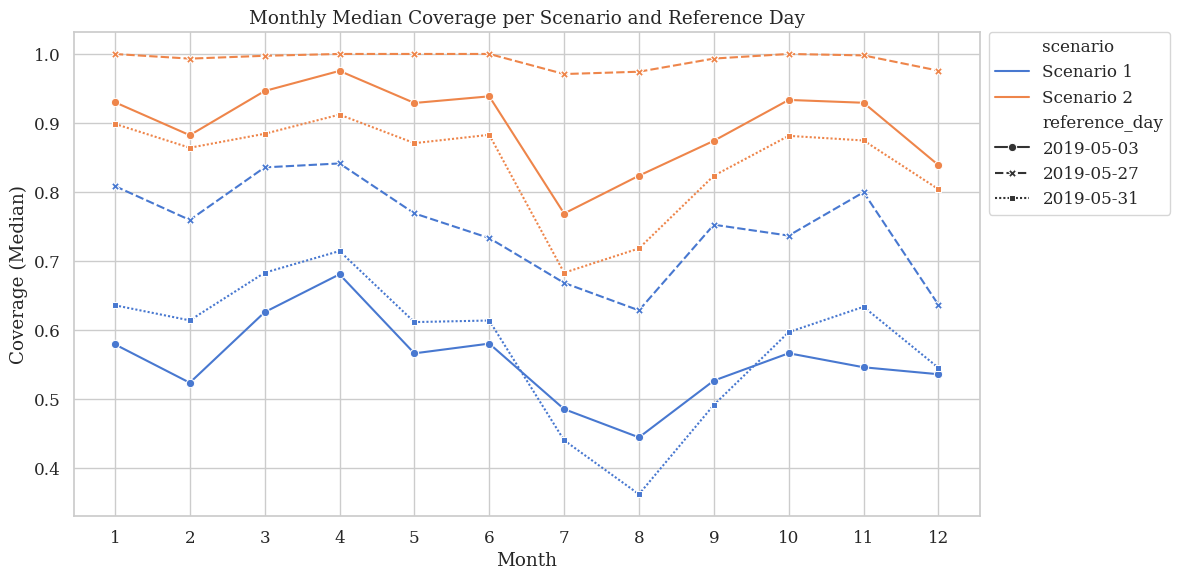

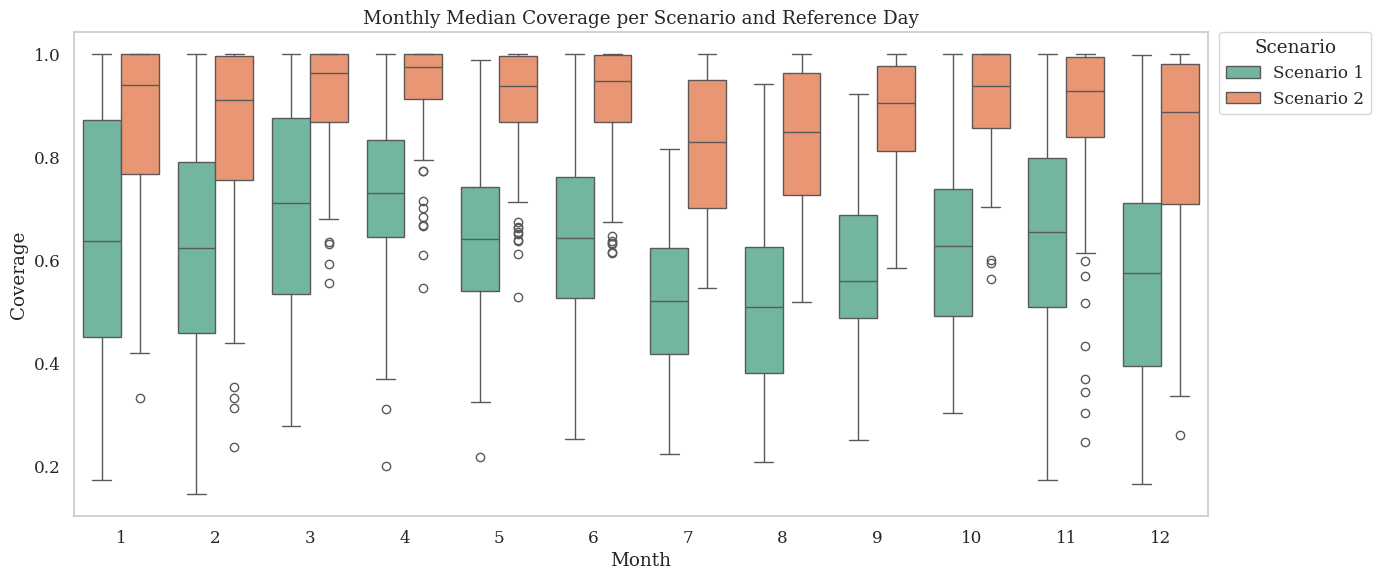

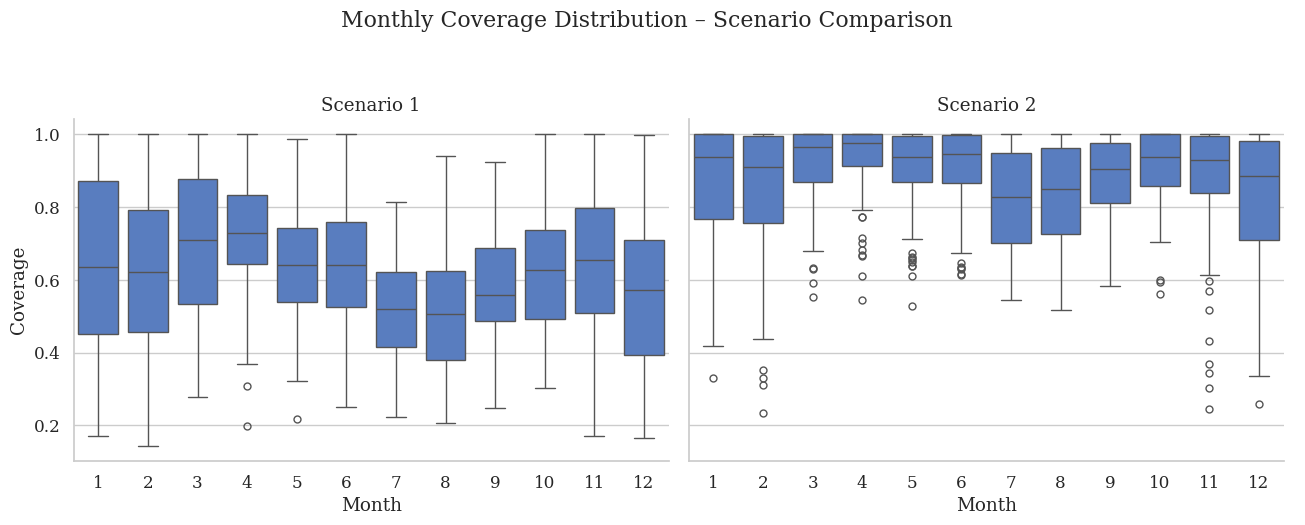

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl

# === Style === #
mpl.rcParams['font.family'] = 'serif'

# === Parameters === #
files = [
    "coverage_scenario1_2019-05-03.csv",
    "coverage_scenario1_2019-05-27.csv",
    "coverage_scenario1_2019-05-31.csv",
    "coverage_scenario2_2019-05-03.csv",
    "coverage_scenario2_2019-05-27.csv",
    "coverage_scenario2_2019-05-31.csv",
]

# === Collect all data in list === #
all_data = []

# === Load all CSVs and label by scenario and reference day === #
for file in files:
    df = pd.read_csv(file, parse_dates=["date"])
    scenario = "Scenario 1" if "scenario1" in file else "Scenario 2"
    day = file.split("_")[-1].split(".")[0]
    df["scenario"] = scenario
    df["reference_day"] = day
    df["month"] = df["date"].dt.month
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# === 1. Monthly median coverage table === #
monthly_medians = (
    combined_df.groupby(["scenario", "reference_day", "month"])["coverage"]
    .median()
    .reset_index()
    .pivot_table(index="month", columns=["scenario", "reference_day"], values="coverage")
)
print("Monthly median coverage:")
print(monthly_medians.round(3))

# === 2. Line plot of monthly medians === #
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df,
    x="month",
    y="coverage",
    hue="scenario",
    style="reference_day",
    markers=True,
    estimator="median",
    ci=None
)
plt.title("Monthly Median Coverage per Scenario and Reference Day")
plt.xlabel("Month")
plt.ylabel("Coverage (Median)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(
    bbox_to_anchor=(1.01, 1),  # Position: slightly outside right
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout()

plt.show()

# Plot
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=combined_df,
    x="month",
    y="coverage",
    hue="scenario",
    palette="Set2"
)

plt.title("Monthly Median Coverage per Scenario and Reference Day")
plt.xlabel("Month")  # Updated from "Monat"
plt.ylabel("Coverage")
plt.xticks(ticks=range(12), labels=[str(i + 1) for i in range(12)], rotation=0)  # Show 1–12
plt.grid(axis='y')

# Legend outside top right
plt.legend(
    title="Scenario",
    bbox_to_anchor=(1.01, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()

# === 3. Boxplots by month, separated by scenario === #
g = sns.catplot(
    data=combined_df,
    x="month",
    y="coverage",
    col="scenario",
    kind="box",
    height=5,
    aspect=1.3,
    col_order=["Scenario 1", "Scenario 2"]
)
g.set_axis_labels("Month", "Coverage")
g.set_titles("{col_name}")
plt.suptitle("Monthly Coverage Distribution – Scenario Comparison", y=1.05)
plt.tight_layout()
plt.show()


/tmp/ipykernel_626/2694449484.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="month", y="improvement", jitter=0.25, alpha=0.7, size=4, palette="coolwarm", edgecolor="gray")
/tmp/ipykernel_626/2694449484.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df, x="month", y="improvement", jitter=0.25, alpha=0.7, size=4, palette="coolwarm", edgecolor="gray")


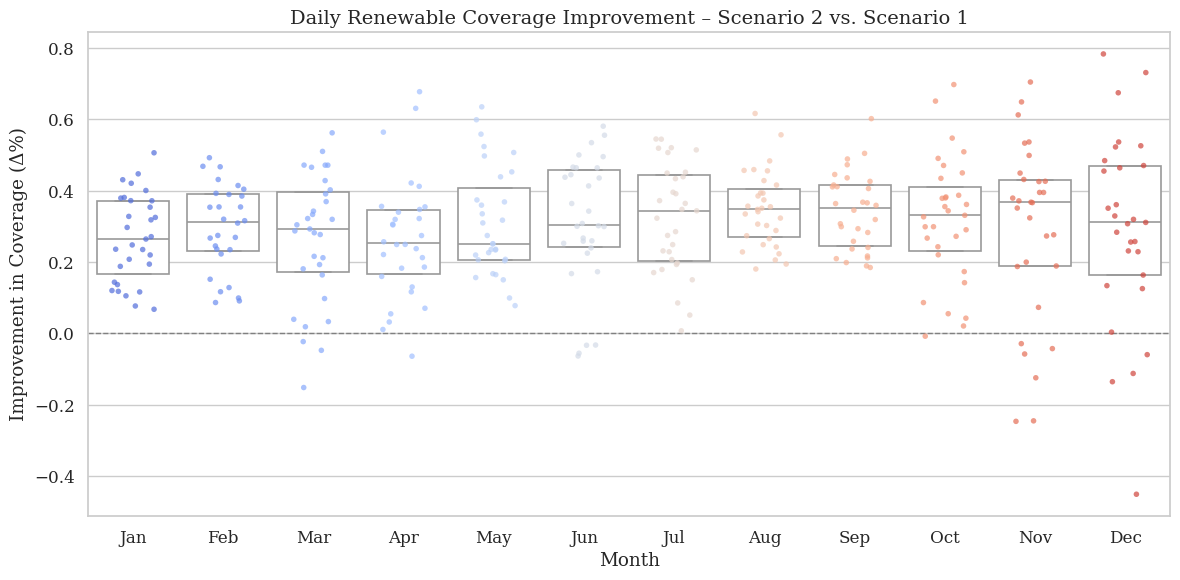

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load coverage data === #
s1 = pd.read_csv("coverage_scenario1_2019-05-03.csv", parse_dates=["date"])
s2 = pd.read_csv("coverage_scenario2_2019-05-03.csv", parse_dates=["date"])

# === Calculate improvement === #
df = s1.copy()
df["coverage_s2"] = s2["coverage"]
df["improvement"] = df["coverage_s2"] - df["coverage"]
df["month"] = df["date"].dt.strftime("%b")  # e.g., Jan, Feb, ...

# === Plot === #
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x="month", y="improvement", jitter=0.25, alpha=0.7, size=4, palette="coolwarm", edgecolor="gray")
sns.boxplot(data=df, x="month", y="improvement", whis=0, color="white", linewidth=1.2, fliersize=0)

plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.title("Daily Renewable Coverage Improvement – Scenario 2 vs. Scenario 1", fontsize=14)
plt.ylabel("Improvement in Coverage (Δ%)")
plt.xlabel("Month")
plt.tight_layout()

plt.show()


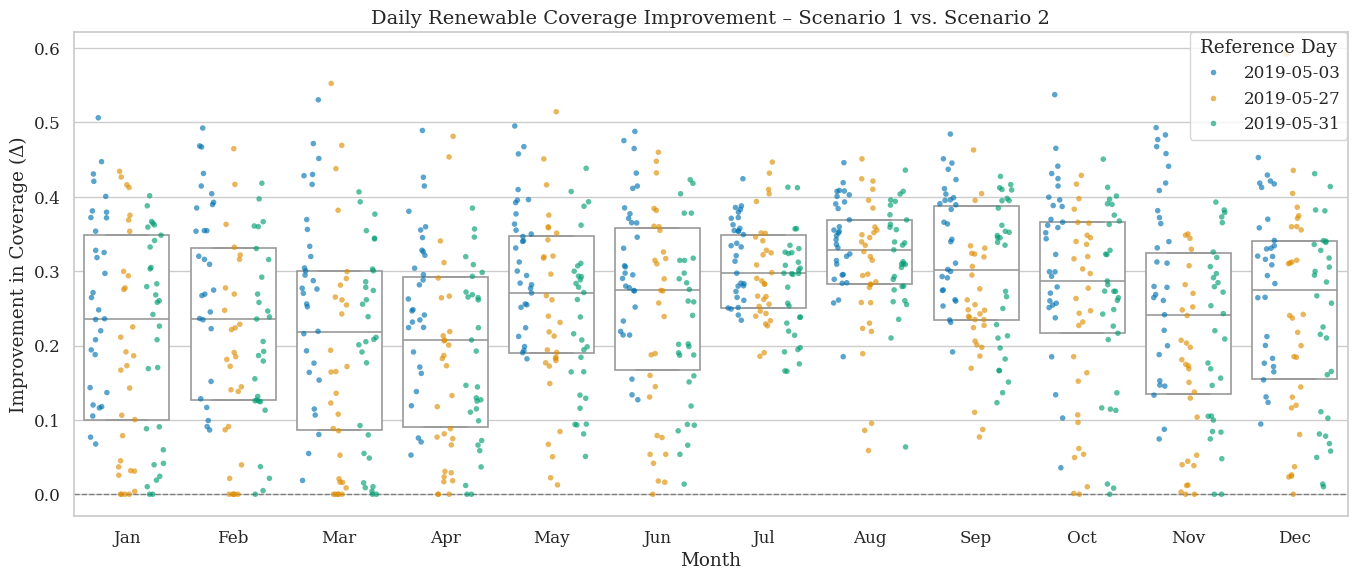

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reference days
reference_days = ["2019-05-03", "2019-05-27", "2019-05-31"]
frames = []

# Load and merge data
for ref_day in reference_days:
    s1 = pd.read_csv(f"coverage_scenario1_{ref_day}.csv", parse_dates=["date"])
    s2 = pd.read_csv(f"coverage_scenario2_{ref_day}.csv", parse_dates=["date"])
    
    df = pd.merge(s1, s2, on="date", suffixes=("_s1", "_s2"))
    df["improvement"] = df["coverage_s2"] - df["coverage_s1"]
    df["month"] = df["date"].dt.strftime("%b")
    df["reference_day"] = ref_day
    frames.append(df)

# Combine into single DataFrame
combined_df = pd.concat(frames)

# Use a colorblind-friendly palette or custom-defined colors
custom_palette = sns.color_palette("colorblind")[:3] 

# Plot
plt.figure(figsize=(14, 6))
sns.stripplot(
    data=combined_df,
    x="month",
    y="improvement",
    hue="reference_day",
    jitter=0.25,
    alpha=0.65,
    size=4,
    palette=custom_palette,
    dodge=True
)

sns.boxplot(
    data=combined_df,
    x="month",
    y="improvement",
    whis=0,
    color="white",
    linewidth=1.2,
    fliersize=0
)

plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.title("Daily Renewable Coverage Improvement – Scenario 1 vs. Scenario 2", fontsize=14)
plt.ylabel("Improvement in Coverage (Δ)")
plt.xlabel("Month")
# Legend top right
plt.legend(
    title="Reference Day",
    bbox_to_anchor=(0.876, 1),  # Position: slightly outside right
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout()
plt.show()
